In [1]:
if __name__=="__main__":
	import sys
	sys.path.append('/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/Scripts')

from src.SMT_Analysis_BP.databases.trajectory_analysis_script import *
from scipy.interpolate import griddata
from scipy.stats import norm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.colors
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from scipy.stats import gaussian_kde
import pandas as pd
import os
import numpy as np
from src.SMT_Analysis_BP.helpers.plotting_functions import *
from src.SMT_Analysis_BP.helpers.import_functions import *
from src.SMT_Analysis_BP.helpers.Analysis_functions import *
from src.SMT_Analysis_BP.helpers.diff_mw import *
import mpl_toolkits.mplot3d.art3d as art3d
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib as mpl
from src.SMT_Analysis_BP.helpers.scalebars import *
from src.SMT_Analysis_BP.helpers.Convert_csv_mat import *
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
from scipy import stats, ndimage,io
import csv  
from sklearn.cluster import OPTICS
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')  
from sklearn.cluster import DBSCAN
from cgitb import small
import src.SMT_Analysis_BP.helpers.smallestenclosingcircle as smallestenclosingcircle
import math
import src.SMT_Analysis_BP.helpers.guassian_fit as gaussian_fit
import src.SMT_Analysis_BP.helpers.fbm_utility as fbm_utility
import src.SMT_Analysis_BP.helpers.simulate_foci as simulate_foci
import src.SMT_Analysis_BP.helpers.simulate_cells as simulate_cells
import src.SMT_Analysis_BP.helpers.SMT_converters as smt
import matplotlib.patches as mpatches
import pickle

/var/folders/_t/qlzp5l894v16vmr8m_81x5x80000gn/T/ipykernel_9918/2873649675.py:38: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg')


In [2]:
globals = {"olympus_pixel_size":130,"confocal_pixel_size":79}
from warnings import filterwarnings
filterwarnings('ignore',module="DeprecationWarning")
#ignore deprecated warnings
#ignore stacklevel=2 warnings

In [3]:
#cell parameters
cell_parms = {
    "diffusion_coefficients":np.array(list(0.1*np.ones(100)) + list(0.5*np.ones(100))),
    "initials":np.random.uniform(20,180,(200,2)),#np.ones((100,2))*np.array([100,100]),#xy,#np.ones((10,2))*np.array([100,100]),#np.random.uniform(50,150,(200,2)),
    "num_tracks":200,
    "track_type":"fbm",
    "hursts":np.array(list(0.2*np.ones(100)) + list(0.5*np.ones(100))),
    "dims":(200,200),
    "movie_frames":500
}      

#sim_params
sim_params = {
    "track_length_mean":20,
    "track_distribution":"constant",
    "exposure_time":20,#ms same as frame_time
    "base_noise":140,
    "point_intensity":20,
    "psf_sigma":130./130.,
    "frame_time":20,#ms
    "pixel_size":globals["olympus_pixel_size"],
    "axial_function":"ones"
}
cell_sim = simulate_cells.Simulate_cells(cell_parms,sim_params)
a = cell_sim.get_cell()


2023-08-31 01:34:53.030427: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-08-31 01:34:53.030558: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M2

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



In [4]:
#radius of confinment fucntion
def radius_of_confinement(t,r_sqr,D,loc_msd):
    return (r_sqr**2)*(1.-np.exp(-4*D*t/(r_sqr**2))) + 4*(loc_msd**2)

In [5]:
#radius of confinment fucntion
def radius_of_confinement_xy(t,r_sqr,D,loc_msd_x,loc_msd_y):
    return (r_sqr**2)*(1.-np.exp(-4*D*t/(r_sqr**2))) + 4*(loc_msd_x**2) + 4*(loc_msd_y**2)

In [6]:
#power law function
def power_law(t,alpha,D,loc_msd_x,loc_msd_y):
    return 4*(loc_msd_x**2) + 4*(loc_msd_y**2) + 4.*D*t**(alpha)

In [7]:
#def open the pickeled data
def open_pickle_data(path,which="tracks"):
    with open(path+"/Track_dump.pkl", 'rb') as f:
        data = pickle.load(f)
    true_tracks = cell_sim._convert_track_dict_msd(data[which])
    return true_tracks

def msd_calc(track_dic,h=None,tau_lim=None,tick_space=2,save=False,cd=None,data_type=None,plot=True,msd_fit_lim=3,convert=None):
    '''Docstring for msd_calc, this is just a fancy wrapper for the MSD_Tracks function in the Analysis_functions module that also does some plotting
    Not very useful for anything other than plotting the MSD curves for a set of tracks.
    MSD calculations can be done using this but it is obtuse and not recommended. See MSD_Tracks for a better way to do this.

    Parameters:
    -----------
    track_dic: dictionary
        dictionary of tracks with the keys being the track number and the values being the track
    h: float
        True husrt value for the simulation, if None this does not get plotted
    tau_lim: int
        The maximum tau value to plot, if None then this is set to the maximum tau value. Only used if plot is True
    tick_space: int
        Total ticks for colorbar in Van hove Correlation Plot, only used if plot is True
    save: bool
        If True then the plot is saved to the specified directory
    cd: str
        The directory to save the plot to, only used if save is True
    data_type: str
        The type of data that is being plotted, only used if save is True. This is the name of the folder that the plot is saved to
    plot: bool
        If True then the plot is plotted
    msd_fit_lim: int, array-like of length 2, or None, optional
        The number of points to fit the line to for the alpha value
        if array then the first value is the lower limit and the second value is the upper limit to fit for tau
    convert: Default, None (takes values in um for the pixel->um conversion)
        covert pixel to um
    

    Returns:
    --------
    Dict containing:
    fit_ens: array
        The fit parameters for the ensemble of tracks
    track_alpha: dict
        The alpha values for each track
    tavg_t1_msd: dict
        The time averaged msd for tau = 1
    track_msds: dict
        The msd curves for each track
    track_alpha_linear_fit: dict
        The linear fit parameters for each track
    track_diffusion: dict
        The diffusion coefficient for each track using a polynomial fit
    track_diffusion_linear_fit: dict
        The diffusion coefficient for each track using a linear fit
    
    

    '''
    #if save is True and cd is None then raise an error
    if save:
        if cd is None:
            raise ValueError("cd must be specified if save is True")
        if data_type is None:
            raise ValueError("data_type must be specified if save is True")

    msd_dict,ens_displacements = MSD_Tracks(track_dic,permutation=True,return_type="both",verbose=True,conversion_factor=convert)
    msd = msd_dict["msd_curves"][0]
    msd_error = msd_dict["msd_curves"][1]
    disp_per_track = msd_dict["displacements"]
    #update the disp_per_track dictionary to have the msd curve per track
    track_msds = {}
    for i,j in disp_per_track.items():
        track_msds[i] = msd_avgerage_utility(j)[0]
    #fit a line to the msd curves for the first n of the points and find the r2 value
    try:
        fit_num = 15
        fit_num_lower = 0
        if isinstance(msd_fit_lim,int):
            fit_ens = np.polyfit(np.log(list(msd.keys())[:msd_fit_lim]),np.log(list(msd.values())[:msd_fit_lim]),1,cov=True)
            
        elif isinstance(msd_fit_lim,list|tuple|np.ndarray):
            fit_ens = np.polyfit(np.log(list(msd.keys())[msd_fit_lim[0]:msd_fit_lim[1]]),np.log(list(msd.values())[msd_fit_lim[0]:msd_fit_lim[1]]),1,cov=True)
            #fit_ens = np.polyfit(np.log(list(msd.keys())[-15:-6]),np.log(list(msd.values())[-15:-6]),1,cov=True)
        #fit_ens = np.polyfit(np.log(list(msd.keys())[fit_num_lower:fit_num]),np.log(list(msd.values())[fit_num_lower:fit_num]),1,cov=True)
        slope_error = np.sqrt(fit_ens[1])
        #fit the first 12 time points to the radius_of_confinement function
        fit_ens_con,pcov_fit_ens_con = curve_fit(radius_of_confinement_xy,0.02*(np.array(list(msd.keys()))[fit_num_lower:fit_num]),np.array(list(msd.values()))[fit_num_lower:fit_num],p0=[1,0.3,0.01,0.01],method='lm')
        fit_ens_power_law,fit_ens_power_law_con = curve_fit(power_law,0.02*(np.array(list(msd.keys()))[fit_num_lower:fit_num]),np.array(list(msd.values()))[fit_num_lower:fit_num],p0=[1,1,0.03,0.03],method='lm')
        print(fit_ens)
        print(fit_ens_con,pcov_fit_ens_con)
        print(fit_ens_power_law,fit_ens_power_law_con)
        #plot this fit
        if plot:
            plt.errorbar(0.02*(np.array(list(msd.keys()))[fit_num_lower:fit_num]),np.array(list(msd.values()))[fit_num_lower:fit_num],yerr=np.array(list(msd_error.values())[fit_num_lower:fit_num])*1.96,fmt="o",label="Ensemble MSD")
            plt.plot(0.02*(np.array(list(msd.keys()))[fit_num_lower:fit_num]),radius_of_confinement_xy(0.02*(np.array(list(msd.keys()))[fit_num_lower:fit_num]),*fit_ens_con),label="Radius of Confinement Fit")
            plt.legend()
            plt.xlabel("Time (s)")
            plt.ylabel("MSD (um^2)")
            plt.yscale("log")
            plt.xscale("log")
            plt.show()
            plt.errorbar(0.02*(np.array(list(msd.keys()))[fit_num_lower:fit_num]),np.array(list(msd.values()))[fit_num_lower:fit_num],yerr=np.array(list(msd_error.values())[fit_num_lower:fit_num])*1.96,fmt="o",label="Ensemble MSD")
            plt.plot(0.02*(np.array(list(msd.keys()))[fit_num_lower:fit_num]),power_law(0.02*(np.array(list(msd.keys()))[fit_num_lower:fit_num]),*fit_ens_power_law),label="Power Law Fit")
            plt.legend()
            plt.xlabel("Time (s)")
            plt.ylabel("MSD (um^2)")
            plt.yscale("log")
            plt.xscale("log")
            plt.title("Power_law")
            plt.show()

    except:
        fit_ens = None
        slope_error = None

    track_alphas = {}
    track_alphas_linear_fit = {}
    tavg_t1_msds = {}
    track_diffusion = {}
    track_diffusion_linear_fit = {}
    loc_err = {}
    d_app_loc_corr = {}
    # for each track plot the msd_curve 
    for i,j in track_msds.items():
        #make sure the length of the track is greater than 3 so that the fit can be done
        if len(j.keys())<3:
            continue
        #set the alpha to be 0.1 so that the lines are transparent
        #if plot:
        #    plt.plot(j.keys(),j.values(),alpha=0.1)
        #fit a line to the msd curves for the first 3 of the points and find the r2 value
        if isinstance(msd_fit_lim,int):
            #fit,pcov = curve_fit(fit_MSD_Linear,np.log(list(j.keys())[:msd_fit_lim]),np.log(list(j.values())[:msd_fit_lim]),p0=[1,1])
            #repeat this with fitting the msd to a the function fit_MSD from Analysis_functions using curve_fit
            fit_curve,pcov = curve_fit(fit_MSD,list(j.keys())[:msd_fit_lim],list(j.values())[:msd_fit_lim],p0=[1,1,0],maxfev=1000000)
            #fit using the loc_error function
            fit_curve_loc,pcov_loc = curve_fit(fit_MSD_loc_err,list(j.keys())[:msd_fit_lim],list(j.values())[:msd_fit_lim],p0=[1,1,1],maxfev=1000000)
        elif isinstance(msd_fit_lim,list|tuple|np.ndarray):
            #fit,pcov = curve_fit(fit_MSD_Linear,np.log(list(j.keys())[msd_fit_lim[0]:msd_fit_lim[1]]),np.log(list(j.values())[msd_fit_lim[0]:msd_fit_lim[1]]),p0=[1,1])
            #repeat this with fitting the msd to a the function fit_MSD from Analysis_functions using curve_fit
            fit_curve,pcov = curve_fit(fit_MSD,list(j.keys())[msd_fit_lim[0]:msd_fit_lim[1]],list(j.values())[msd_fit_lim[0]:msd_fit_lim[1]],p0=[1,1,0],maxfev=1000000)
            #fit using the loc_error function
            fit_curve_loc,pcov_loc = curve_fit(fit_MSD_loc_err,list(j.keys())[msd_fit_lim[0]:msd_fit_lim[1]],list(j.values())[msd_fit_lim[0]:msd_fit_lim[1]],p0=[0.045,0.2,1],maxfev=1000000)
        #plot the fitted line
        #if plot and fit_curve[1]<0:
        #     plt.plot(list(j.keys())[:msd_fit_lim],fit_MSD(list(j.keys())[:msd_fit_lim],fit_curve[0],fit_curve[1]),alpha=0.1)
        #     plt.plot(j.keys(),j.values(),alpha=0.1)
        # plt.show()
        if plot:
            plt.plot(list(j.keys()),np.array(list(j.values())),alpha=0.1)
        #add the slope of the fitted line to the track_alphas dictionary
        #track_alphas_linear_fit[i] = fit[1]
        track_alphas[i] = fit_curve[1]
        #add the msd at tau=1 to the tavg_t1_msds dictionary, divide by 4 to get the correct value t is by default 1 since its tau=1
        tavg_t1_msds[i] = j[1]/4.
        track_diffusion[i] = fit_curve[0]/4.
        #track_diffusion_linear_fit[i] = np.exp(fit[0])/4.
        loc_err[i] = fit_curve_loc[2]
        d_app_loc_corr[i] = fit_curve_loc[0]/4.
        
    if plot:
        #plot the msd curves and the fitted line
        plt.plot(list(msd.keys())[:fit_num],np.array(list(msd.values()))[:fit_num],label="MSD_ensemble",linewidth=3,alpha=1,zorder=1)
        if fit_ens != None:
            plt.plot(list(msd.keys())[:fit_num],np.exp(fit_ens[0][1])*(np.array(list(msd.keys()))[:fit_num])**fit_ens[0][0],label="fit_ensemble",linewidth=3,alpha=1,zorder=2)

        plt.xscale("log")
        plt.yscale("log")
        #label the plot
        plt.xlabel("lag time (au)")
        plt.ylabel("MSD (au)")
        plt.legend()
        #annotate the plot with the slope of the fitted line with 2 decimal places (label the slope as alpha in greek)
        #add the error in the slope as well
        #plt.annotate(r"$\alpha$ = {:.2f} $\pm$ {:.2f}".format(fit_ens[0][0],slope_error[0][0]),xy=(0.05,0.7),xycoords="axes fraction",fontweight="bold",fontsize=16)
        #annotate the true alpha value (hurst*2)
        if h != None:
            plt.annotate(r"True $\alpha$ = {:.2f}".format(h*2),xy=(0.05,0.6),xycoords="axes fraction",fontweight="bold",fontsize=16)
        if save == True:
            plt.savefig(cd+"/{0}_MSD_plot.png".format(data_type))
        plt.show()

        #repeat on a linear-linear plot
        #plot the msd curves and the fitted line
        plt.errorbar(list(msd.keys())[:fit_num],np.array(list(msd.values()))[:fit_num],yerr=np.array(list(msd_error.values()))[:fit_num]*1.96,label="MSD_ensemble",linewidth=3,alpha=1,zorder=1)
        if fit_ens != None:
            plt.plot(list(msd.keys())[:fit_num],np.exp(fit_ens[0][1])*(np.array(list(msd.keys()))[:fit_num])**fit_ens[0][0],label="fit_ensemble",linewidth=3,alpha=1,zorder=2)

        # plt.xscale("log")
        # plt.yscale("log")
        #label the plot
        plt.xlabel("lag time (au)")
        plt.ylabel("MSD (au)")
        plt.legend()
        #annotate the plot with the slope of the fitted line with 2 decimal places (label the slope as alpha in greek)
        #add the error in the slope as well
        #plt.annotate(r"$\alpha$ = {:.2f} $\pm$ {:.2f}".format(fit_ens[0][0],slope_error[0][0]),xy=(0.05,0.7),xycoords="axes fraction",fontweight="bold",fontsize=16)
        #annotate the true alpha value (hurst*2)
        if h != None:
            plt.annotate(r"True $\alpha$ = {:.2f}".format(h*2),xy=(0.05,0.6),xycoords="axes fraction",fontweight="bold",fontsize=16)
        if save == True:
            plt.savefig(cd+"/{0}_MSD_plot.png".format(data_type))
        plt.show()

        #on a new figure plot the histogram of the slopes of the fitted lines
        plt.clf()
        plt.hist(list(track_alphas.values()),bins=10)
        #plot a vertical line at the mean of the track_alphas
        plt.axvline(np.mean(list(track_alphas.values())),color="red",label="mean")
        #annotate the plot with the mean of the track_alphas
        #plt.annotate(r"$\alpha$ = {:.2f}".format(np.mean(list(track_alphas.values()))),xy=(0.05,0.7),xycoords="axes fraction",fontweight="bold",fontsize=16)
        plt.xlabel(r"$\alpha$")
        plt.ylabel("count")
        if save == True:
            plt.savefig(cd+"/{0}_alpha_hist.png".format(data_type))
        plt.show()

        #repeat the above for the track_alphas_linear_fit
        plt.clf()
        plt.hist(list(track_alphas_linear_fit.values()),bins=10)
        plt.axvline(np.mean(list(track_alphas_linear_fit.values())),color="red",label="mean")
        #plt.annotate(r"$\alpha$ = {:.2f}".format(np.mean(list(track_alphas_linear_fit.values()))),xy=(0.05,0.7),xycoords="axes fraction",fontweight="bold",fontsize=16)
        plt.xlabel(r"$\alpha$")
        plt.ylabel("count")
        if save == True:
            plt.savefig(cd+"/{0}_alpha_hist_linear_fit.png".format(data_type))
        plt.show()

    #the following plots the pdf of the displacements for each tau, right now it sometimes creates infinite loops so it is commented out TODO: fix this
    if plot:
        #make a figure and axes 2 subplots
        fig,ax = plt.subplots(1,2,figsize=(20,10))

        #get a collection of N different colours where N is the number of taus
        colors = plt.cm.jet(np.linspace(0,1,len(ens_displacements.keys())))

    #make a df to store the tau value and the fitted gmm mean for that tau
    gmm_tau_df = pd.DataFrame(columns=["tau","mean","sigma"])
    #make a histogram of the displacements for each tau from ens_displacements
    for i,j in ens_displacements.items():
        #convert to r
        j_r = np.sqrt(np.sum(np.array(j)**2,axis=1))
        #if the tau is greater than the tau_lim then skip it
        if (tau_lim != None):
            if i > tau_lim: 
                continue
        if plot:
            #make the histogram normalized and transparent for the first subplot
            ax[0].hist(np.ndarray.flatten(np.array(j)),bins=100,alpha=0.1,color=colors[i-1],density=True)#,stacked=True,weights=np.ones(len(np.ndarray.flatten(np.array(j))))/len(np.ndarray.flatten(np.array(j))))
            #make the histogram normalized and transparent for the second subplot for abs displacements
            ax[1].hist(np.abs(np.ndarray.flatten(np.array(j_r))),bins=100,alpha=0.1,color=colors[i-1],density=True)#,stacked=True,weights=np.ones(len(np.ndarray.flatten(np.array(j))))/len(np.ndarray.flatten(np.array(j))))
            pass
        #fit a gaussian to the histogram
        mu,sigma = norm.fit(np.ndarray.flatten(np.array(j)))
        #fit it for the abs displacements as well
        mu_abs,sigma_abs = norm.fit(np.abs(np.ndarray.flatten(np.array(j))))
        #store the tau and the mean of the gaussian in the df
        gmm_tau_df = gmm_tau_df.append({"tau":i,"mean":mu_abs,"sigma":sigma_abs**2},ignore_index=True)
        if plot:
            #plot the gaussian
            x = np.linspace(np.min(np.ndarray.flatten(np.array(j))),np.max(np.ndarray.flatten(np.array(j))),100)
            x_abs = np.linspace(np.min(np.abs(np.ndarray.flatten(np.array(j_r)))),np.max(np.abs(np.ndarray.flatten(np.array(j_r)))),100)
            ax[0].plot(x,norm.pdf(x,mu,sigma),linewidth=1,color=colors[i-1])
            ax[1].plot(x_abs,norm.pdf(x_abs,mu_abs,sigma_abs),linewidth=1,color=colors[i-1])

    if plot:
        #label the plot, in greek the delta_x is P_delta_x
        ax[0].set_xlabel(r"$\Delta r$ (au)")
        ax[0].set_ylabel(r"$P_{\Delta r}$ ($au^{-1}$)")
        ax[1].set_xlabel(r"$|\Delta r|$ (au)")
        ax[1].set_ylabel(r"$P_{|\Delta r|}$ ($au^{-1}$)")
        ax[0].set_yscale("log")

        v1 = np.linspace(np.min(np.array(list(ens_displacements.keys()),dtype=int)), np.max(np.array(list(ens_displacements.keys()),dtype=int)), tick_space, endpoint=True)
        #rather than a legend, make a colorbar with the colors corresponding to the taus
        cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=plt.cm.jet),ticks=v1,ax=ax[0])
        cbar.ax.set_yticklabels(["{:4.2f}".format(i) for i in v1])

        cbar.set_label("tau (au)")


        #make the title
        ax[0].set_title("PDF of displacements for each tau (van Hove correlation)")
        #ax[0].set_ylim(0,1.5)
        if save == True:
            plt.savefig(cd+"/{0}_PDF_plot.png".format(data_type))
        plt.show()
        #plot the mean of the gaussian for each tau
        plt.errorbar(gmm_tau_df["tau"],gmm_tau_df["mean"],yerr=gmm_tau_df["sigma"],fmt="o")
        plt.xlabel("tau (au)")
        plt.ylabel("mean of gaussian fit (au)")
        plt.title("Mean of gaussian fit for each tau")
        plt.show()

    return {"fit_ens":fit_ens, 
            "track_alpha":track_alphas, 
            "tavg_t1_msd":tavg_t1_msds, 
            "track_msds":track_msds, 
            "track_alpha_linear_fit":track_alphas_linear_fit,
            "track_diffusion":track_diffusion,
            "track_diffusion_linear_fit":track_diffusion_linear_fit,
            "D_app_loc_corr":d_app_loc_corr,
            "loc_err":loc_err,
            "msd_curve_ens":msd,
            "msd_curve_ens_err":msd_error,
            "Displacements_per_track": disp_per_track,
            "Track_msds":track_msds,
            "ens_displacements":ens_displacements}
#load the extracted data
def read_data(wd):
    
    rp_ez= run_analysis(wd=wd,
                    t_string="test_seg",sim=True)
                    
    rp_ez.read_parameters(minimum_percent_per_drop_in = 0.5, 
                        t_len_u = 500, 
                        t_len_l=1, 
                        minimum_tracks_per_drop = 3,
                        frame_step=1000,
                        frame_total=1000)

    rp_ez.get_blob_parameters(threshold=1e-2,
                            overlap=0,
                            detection_name='bp',
                            min_sigma=1/np.sqrt(2),
                            max_sigma=6/np.sqrt(2),
                            num_sigma=500,median = False)

    rp_ez.get_fitting_parameters(kwargs={"mask_size":3,
                                        "plot_fit":False,
                                        "fitting_image":"Original",
                                        "radius_func":identity,
                                        "residual_func":residuals_gaus2d,
                                        "sigma_range":2,
                                        "centroid_range":0.5,
                                        "height_range":2})
    tem = rp_ez.run_flow_sim(wd,"test_seg")
    track_dict = rp_ez._convert_to_track_dict_bulk()
    rp_ez.mat_path_dir = wd + "/Analysis/" + "test_seg" + "MATLAB_dat/"
    #make a directory rp_ez.mat_path_dir if it doesn't exist and make two subdirectories nameed "true" and "extracted"
    if not os.path.exists(rp_ez.mat_path_dir):
        os.makedirs(rp_ez.mat_path_dir)
        os.makedirs(rp_ez.mat_path_dir+"/true")
        os.makedirs(rp_ez.mat_path_dir+"/extracted")
    SMAUG_extracted = smt.convert_track_data_SMAUG_format(track_dict["ALL"])
    #save this to the extracted folder as a .mat file using scipy.io.savemat
    io.savemat(rp_ez.mat_path_dir+"/extracted/extracted_track_data.mat",{"trfile":SMAUG_extracted})
    true = open_pickle_data(wd)
    #convert the extracted data to the SMT SMAUG format
    SMAUG_true = smt.convert_track_data_SMAUG_format(true)
    #save this to the true folder as a .mat file using scipy.io.savemat
    io.savemat(rp_ez.mat_path_dir+"/true/true_track_data.mat",{"trfile":SMAUG_true})
    return track_dict



In [72]:
#define all the locations of the simulated maps
sim_maps = glob.glob("/Volumes/Baljyot_HD/Sim_Data/sim_SMT_density_noaxial/**")
#remove the subsampling_sim directory
sim_maps = [i for i in sim_maps if "subsampling_sim" not in i]
#find the unique name of each directory
sim_names = [os.path.basename(os.path.normpath(i)) for i in sim_maps]
#find the value of density from the sim_names which occurs after the string"density_"
sim_densities = [float(i.split("density_")[1].split("_")[0]) for i in sim_names]


#define 3 symbols for each of the 3 different types of simulations
symbols = ["x","o","^"]#for hurst=0.2,0.35,0.5
#make a list of marker symbols for each simulation name.
#assign the same symbol to the simulations with the same hurst value
sim_markers = []
for i in sim_names:
    if "h_0.2" in i:
        sim_markers.append(symbols[0])
    elif "h_0.35" in i:
        sim_markers.append(symbols[1])
    elif "h_0.5" in i:
        sim_markers.append(symbols[2])
    else:
        print("Error: Unknown hurst value")
        print(i)
        #sim_markers.append("x")
        break

#make a list of colors for each simulation name.
sim_colors = []
for i in sim_names:
    if "track_100" in i:
        sim_colors.append("red")
    if "track_200" in i:
        sim_colors.append("blue")
    if "track_500" in i:
        sim_colors.append("green")
print(sim_names)
print(sim_colors)
print(sim_markers)
print(sim_densities)
print(sim_maps)

['h_0.2_track_100_diff_0.4_density_0.175', 'h_0.2_track_100_diff_0.4_density_0.263', 'h_0.2_track_100_diff_0.4_density_0.35', 'h_0.2_track_100_diff_0.4_density_0.438', 'h_0.2_track_100_diff_0.4_density_0.525', 'h_0.2_track_100_diff_0.4_density_0.613', 'h_0.2_track_100_diff_0.4_density_0.7', 'h_0.2_track_100_diff_0.4_density_0.787', 'h_0.2_track_100_diff_0.4_density_0.875', 'h_0.2_track_100_diff_0.4_density_0.963', 'h_0.2_track_100_diff_0.4_density_1.05', 'h_0.2_track_100_diff_0.4_density_1.137', 'h_0.2_track_100_diff_0.4_density_1.225', 'h_0.2_track_100_diff_0.4_density_1.312', 'h_0.2_track_100_diff_0.4_density_1.4', 'h_0.2_track_100_diff_0.4_density_1.488', 'h_0.2_track_100_diff_0.4_density_1.575', 'h_0.2_track_100_diff_0.4_density_1.663']
['red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red']
['x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x']
[0.175, 0.263, 0.35, 0.438, 0.5

In [108]:
#for each sim_map open the true track data, and the extracted data
threshold=0.5

point_pair_errors = np.zeros((len(sim_maps)))
linking_errors = np.zeros((len(sim_maps)))

true_tavg_t1_msds = []
extracted_tavg_t1_msds = []

true_alpha = np.zeros((len(sim_maps)))
extracted_alpha = np.zeros((len(sim_maps)))
for i in range(len(sim_maps[:])):
    print("sim_names: {0}".format(sim_names[i]))
    print("sim_maps: {0}".format(sim_maps[i]))
    true_tracks = open_pickle_data(sim_maps[i])
    extracted_tracks = read_data(sim_maps[i])["ALL"]
    true_tracks_frame = points_per_frame_convert(true_tracks)
    extracted_tracks_frame = points_per_frame_convert(extracted_tracks)
    #perform the point_error calculations for the true and extracted tracks
    percent_points_detected = point_error_detection(true_tracks_frame,extracted_tracks_frame,threshold=threshold)
    #find the point pairs for both 
    true_point_pairs = convert_point_pairs(true_tracks)
    extracted_point_pairs = convert_point_pairs(extracted_tracks)
    #perform the point_error calculations for the true and extracted tracks
    percent_point_pairs_detected,linking_ratio = point_pair_error_detection(true_point_pairs,extracted_point_pairs,threshold=threshold)
    #store the percent_point_pairs_detected
    point_pair_errors[i] = percent_point_pairs_detected
    linking_errors[i] = linking_ratio
    msd_true = msd_calc(true_tracks,h=None,tau_lim=1,tick_space=2,save=False,cd=sim_maps[i],data_type="True",plot=False,msd_fit_lim=3)
    msd_extracted = msd_calc(extracted_tracks,h=None,tau_lim=1,tick_space=2,save=False,cd=sim_maps[i],data_type="Extracted",plot=False,msd_fit_lim=3)
    true_tavg_t1_msds.append(msd_true["track_diffusion"])
    extracted_tavg_t1_msds.append(msd_extracted["track_diffusion"])
    true_alpha[i] = np.mean(list(msd_true["track_alpha"].values()))
    extracted_alpha[i] = np.mean(list(msd_extracted["track_alpha"].values()))
    #print("percent_points_detected: {0}".format(percent_points_detected))


sim_names: h_0.2_track_100_diff_0.4_density_0.175
sim_maps: /Volumes/Baljyot_HD/Sim_Data/sim_SMT_density_noaxial/h_0.2_track_100_diff_0.4_density_0.175
['/Volumes/Baljyot_HD/Sim_Data/sim_SMT_density_noaxial/h_0.2_track_100_diff_0.4_density_0.175/Analysis/test_seg.tif_spots.csv']


/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/Scripts/src/SMT_Analysis_BP/helpers/blob_detection.py:420: DeprecationWarning: Please use `gaussian_laplace` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  gl_images = [-filters.gaussian_laplace(image, s) * np.mean(s) ** 2
/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/Scripts/src/SMT_Analysis_BP/databases/trajectory_analysis_script.py:296: DeprecationWarning: Call to deprecated function reshape_col2d (Sometimes this breaks, use with caution. Use array slicing instead (ex: a[:,[0,2,1,3]] to switch the 2nd and 3rd columns)).
  blob["Fitted"] = reshape_col2d(fitted,[1,0,2,3])
/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/Scripts/src/SMT_Analysis_BP/databases/trajectory_analysis_script.py:297: DeprecationWarning: Call to deprecated function reshape_col2d (Sometimes this breaks, use with caution. Use array slicing instead (ex: a[:,[0,2,1,3]] to switch the 2nd and 3rd co

(array([0.43719568, 0.56056706]), array([[ 4.72783569e-05, -2.82371479e-05],
       [-2.82371479e-05,  2.65925310e-05]]))
[ 1.86036245 16.54104549  0.25014587  0.29543617] [[-3.08631548e-02 -2.79231923e+00  2.27694765e+06 -1.92789196e+06]
 [-2.79231913e+00 -4.84174448e+01  1.37494555e+08 -1.16416666e+08]
 [ 2.27694764e+06  1.37494559e+08 -8.68889586e+13  7.35688946e+13]
 [-1.92789196e+06 -1.16416669e+08  7.35688946e+13 -6.22907944e+13]]
[4.12482996e-01 2.28697029e+00 9.24057953e-05 9.28024185e-05] [[ 1.20632556e-01 -5.61724260e-02  8.45843709e+02  4.52482433e+02]
 [-5.61724260e-02  4.87704577e-01 -1.07436408e+03 -2.91212236e+02]
 [ 1.12361385e+03 -1.11187738e+03 -1.32261887e+20  1.33257779e+20]
 [ 1.70721513e+02 -2.51497761e+02  1.33257779e+20 -1.34261169e+20]]


/var/folders/_t/qlzp5l894v16vmr8m_81x5x80000gn/T/ipykernel_9918/2155788557.py:258: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gmm_tau_df = gmm_tau_df.append({"tau":i,"mean":mu_abs,"sigma":sigma_abs**2},ignore_index=True)
/var/folders/_t/qlzp5l894v16vmr8m_81x5x80000gn/T/ipykernel_9918/2155788557.py:85: RuntimeWarning: invalid value encountered in sqrt
  slope_error = np.sqrt(fit_ens[1])
/Users/baljyot/opt/anaconda3/envs/py310/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/var/folders/_t/qlzp5l894v16vmr8m_81x5x80000gn/T/ipykernel_9918/2155788557.py:258: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gmm_tau_df = gmm_tau_df.append({"tau":i,"mean":mu_abs,"si

sim_names: h_0.2_track_100_diff_0.4_density_0.263
sim_maps: /Volumes/Baljyot_HD/Sim_Data/sim_SMT_density_noaxial/h_0.2_track_100_diff_0.4_density_0.263
['/Volumes/Baljyot_HD/Sim_Data/sim_SMT_density_noaxial/h_0.2_track_100_diff_0.4_density_0.263/Analysis/test_seg.tif_spots.csv']


/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/Scripts/src/SMT_Analysis_BP/helpers/blob_detection.py:420: DeprecationWarning: Please use `gaussian_laplace` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  gl_images = [-filters.gaussian_laplace(image, s) * np.mean(s) ** 2
/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/Scripts/src/SMT_Analysis_BP/databases/trajectory_analysis_script.py:296: DeprecationWarning: Call to deprecated function reshape_col2d (Sometimes this breaks, use with caution. Use array slicing instead (ex: a[:,[0,2,1,3]] to switch the 2nd and 3rd columns)).
  blob["Fitted"] = reshape_col2d(fitted,[1,0,2,3])
/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/Scripts/src/SMT_Analysis_BP/databases/trajectory_analysis_script.py:297: DeprecationWarning: Call to deprecated function reshape_col2d (Sometimes this breaks, use with caution. Use array slicing instead (ex: a[:,[0,2,1,3]] to switch the 2nd and 3rd co

(array([0.47466367, 0.64353576]), array([[ 0.00034632, -0.00020684],
       [-0.00020684,  0.00019479]]))
[4.53389105e+02 5.70716618e+00 4.52405569e-01 4.52502335e-01] [[ 4.77118872e+09  7.90751600e+03  2.38964512e+11 -2.38913411e+11]
 [ 7.90751542e+03  5.12795525e-01  3.96047173e+05 -3.95962520e+05]
 [ 2.38964480e+11  3.96047197e+05  3.10011168e+13 -3.09944873e+13]
 [-2.38913379e+11 -3.95962543e+05 -3.09944873e+13  3.09878593e+13]]
[ 4.41805622e-01  2.71411812e+00 -9.45888227e-06  1.71700271e-05] [[inf inf inf inf]
 [inf inf inf inf]
 [inf inf inf inf]
 [inf inf inf inf]]


/var/folders/_t/qlzp5l894v16vmr8m_81x5x80000gn/T/ipykernel_9918/2155788557.py:258: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gmm_tau_df = gmm_tau_df.append({"tau":i,"mean":mu_abs,"sigma":sigma_abs**2},ignore_index=True)
/var/folders/_t/qlzp5l894v16vmr8m_81x5x80000gn/T/ipykernel_9918/2155788557.py:85: RuntimeWarning: invalid value encountered in sqrt
  slope_error = np.sqrt(fit_ens[1])
/Users/baljyot/opt/anaconda3/envs/py310/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


(array([0.48358283, 0.70136523]), array([[ 0.00072332, -0.000432  ],
       [-0.000432  ,  0.00040684]]))
[-2.13595716e+00  3.44663678e+01  2.37328870e-05 -7.35557674e-05] [[ 4.27518118e+00 -2.04309541e+02  2.09335839e+04 -2.03891560e+04]
 [-2.04309541e+02  1.64399960e+04 -1.62038439e+05 -4.31433281e+05]
 [ 2.09335839e+04 -1.62038439e+05  2.42177096e+08 -3.30683825e+08]
 [-2.03891560e+04 -4.31433281e+05 -3.30683825e+08  4.79245663e+08]]
[ 1.21556184e-01  1.34071290e+00 -1.41169079e-04  7.30214995e-05] [[ 2.69807307e+01 -2.07866882e+02 -5.19183594e+05  5.36342659e+05]
 [-2.07866882e+02  1.62702954e+03  4.03407446e+06 -4.19804110e+06]
 [-5.19183594e+05  4.03407446e+06  1.00385548e+10 -1.04057082e+10]
 [ 5.36342659e+05 -4.19804110e+06 -1.04057082e+10  1.08364252e+10]]


/var/folders/_t/qlzp5l894v16vmr8m_81x5x80000gn/T/ipykernel_9918/2155788557.py:258: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gmm_tau_df = gmm_tau_df.append({"tau":i,"mean":mu_abs,"sigma":sigma_abs**2},ignore_index=True)


sim_names: h_0.2_track_100_diff_0.4_density_0.35
sim_maps: /Volumes/Baljyot_HD/Sim_Data/sim_SMT_density_noaxial/h_0.2_track_100_diff_0.4_density_0.35
['/Volumes/Baljyot_HD/Sim_Data/sim_SMT_density_noaxial/h_0.2_track_100_diff_0.4_density_0.35/Analysis/test_seg.tif_spots.csv']


/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/Scripts/src/SMT_Analysis_BP/helpers/blob_detection.py:420: DeprecationWarning: Please use `gaussian_laplace` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  gl_images = [-filters.gaussian_laplace(image, s) * np.mean(s) ** 2
/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/Scripts/src/SMT_Analysis_BP/databases/trajectory_analysis_script.py:296: DeprecationWarning: Call to deprecated function reshape_col2d (Sometimes this breaks, use with caution. Use array slicing instead (ex: a[:,[0,2,1,3]] to switch the 2nd and 3rd columns)).
  blob["Fitted"] = reshape_col2d(fitted,[1,0,2,3])
/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/Scripts/src/SMT_Analysis_BP/databases/trajectory_analysis_script.py:297: DeprecationWarning: Call to deprecated function reshape_col2d (Sometimes this breaks, use with caution. Use array slicing instead (ex: a[:,[0,2,1,3]] to switch the 2nd and 3rd co

(array([0.39200962, 0.67855306]), array([[ 0.00039152, -0.00023384],
       [-0.00023384,  0.00022022]]))
[-1.83147432 12.31593635  0.37060289  0.37346336] [[ 2.73828762e-03  5.36010414e-02  6.11770639e-04 -1.23706544e-03]
 [ 5.36010414e-02  5.88798968e+00 -4.41803691e-02 -1.09198526e-01]
 [ 9.39596073e-04  6.70073461e-02 -6.72812961e+11  6.67659664e+11]
 [-1.56237995e-03 -2.19534617e-01  6.67659664e+11 -6.62545838e+11]]
[ 3.78287096e-01  2.19749059e+00 -2.18547835e-05 -2.18547833e-05] [[inf inf inf inf]
 [inf inf inf inf]
 [inf inf inf inf]
 [inf inf inf inf]]


/var/folders/_t/qlzp5l894v16vmr8m_81x5x80000gn/T/ipykernel_9918/2155788557.py:258: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gmm_tau_df = gmm_tau_df.append({"tau":i,"mean":mu_abs,"sigma":sigma_abs**2},ignore_index=True)
/var/folders/_t/qlzp5l894v16vmr8m_81x5x80000gn/T/ipykernel_9918/2155788557.py:85: RuntimeWarning: invalid value encountered in sqrt
  slope_error = np.sqrt(fit_ens[1])
/Users/baljyot/opt/anaconda3/envs/py310/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


(array([0.47802853, 0.79635559]), array([[ 3.81344064e-05, -2.27758946e-05],
       [-2.27758946e-05,  2.14493575e-05]]))
[-6.09567140e+00  2.68027074e+01 -1.61772647e-05  2.75628565e-05] [[inf inf inf inf]
 [inf inf inf inf]
 [inf inf inf inf]
 [inf inf inf inf]]
[ 8.60584369e-01  1.60279528e+01 -1.27449658e-04 -1.27453119e-04] [[ 5.01018549e-02  1.23301326e+00  6.07878344e+02 -6.43268795e+02]
 [ 1.23301326e+00  6.57749498e+01  4.01940836e+04 -2.00335146e+04]
 [ 7.01972392e+02  4.41044162e+04 -2.55190579e+21  2.55198719e+21]
 [-7.22498873e+02 -2.37448293e+04  2.55198719e+21 -2.55206860e+21]]


/var/folders/_t/qlzp5l894v16vmr8m_81x5x80000gn/T/ipykernel_9918/2155788557.py:258: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gmm_tau_df = gmm_tau_df.append({"tau":i,"mean":mu_abs,"sigma":sigma_abs**2},ignore_index=True)


sim_names: h_0.2_track_100_diff_0.4_density_0.438
sim_maps: /Volumes/Baljyot_HD/Sim_Data/sim_SMT_density_noaxial/h_0.2_track_100_diff_0.4_density_0.438
['/Volumes/Baljyot_HD/Sim_Data/sim_SMT_density_noaxial/h_0.2_track_100_diff_0.4_density_0.438/Analysis/test_seg.tif_spots.csv']


/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/Scripts/src/SMT_Analysis_BP/helpers/blob_detection.py:420: DeprecationWarning: Please use `gaussian_laplace` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  gl_images = [-filters.gaussian_laplace(image, s) * np.mean(s) ** 2
/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/Scripts/src/SMT_Analysis_BP/databases/trajectory_analysis_script.py:296: DeprecationWarning: Call to deprecated function reshape_col2d (Sometimes this breaks, use with caution. Use array slicing instead (ex: a[:,[0,2,1,3]] to switch the 2nd and 3rd columns)).
  blob["Fitted"] = reshape_col2d(fitted,[1,0,2,3])
/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/Scripts/src/SMT_Analysis_BP/databases/trajectory_analysis_script.py:297: DeprecationWarning: Call to deprecated function reshape_col2d (Sometimes this breaks, use with caution. Use array slicing instead (ex: a[:,[0,2,1,3]] to switch the 2nd and 3rd co

(array([0.41843914, 0.61122852]), array([[ 0.0006306 , -0.00037663],
       [-0.00037663,  0.00035469]]))
[ 1.80894974 12.31472203  0.36184317  0.34090416] [[ 1.15686020e-03 -2.11753244e-02  5.68333990e+02 -6.03241978e+02]
 [-2.11753253e-02  3.43454215e+00 -6.61034317e+05  7.01636265e+05]
 [ 5.68334897e+02 -6.61034311e+05  6.83735354e+11 -7.25731724e+11]
 [-6.03242940e+02  7.01636259e+05 -7.25731724e+11  7.70307592e+11]]
[ 3.88562081e-01  2.15596342e+00 -8.25520725e-06 -8.25520741e-06] [[inf inf inf inf]
 [inf inf inf inf]
 [inf inf inf inf]
 [inf inf inf inf]]


/var/folders/_t/qlzp5l894v16vmr8m_81x5x80000gn/T/ipykernel_9918/2155788557.py:258: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gmm_tau_df = gmm_tau_df.append({"tau":i,"mean":mu_abs,"sigma":sigma_abs**2},ignore_index=True)
/var/folders/_t/qlzp5l894v16vmr8m_81x5x80000gn/T/ipykernel_9918/2155788557.py:85: RuntimeWarning: invalid value encountered in sqrt
  slope_error = np.sqrt(fit_ens[1])
/Users/baljyot/opt/anaconda3/envs/py310/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


(array([0.49986736, 0.74466414]), array([[ 0.00023206, -0.0001386 ],
       [-0.0001386 ,  0.00013053]]))
[8.64979721e+02 1.23105504e+01 3.56333335e-01 3.52694509e-01] [[ 1.68358782e+10 -2.52095777e+04 -5.20735095e+10  5.26107722e+10]
 [-2.52095780e+04  1.73571536e+00 -1.32640465e+06  1.34008913e+06]
 [-5.20735050e+10 -1.32640469e+06  3.16623001e+13 -3.19889672e+13]
 [ 5.26107676e+10  1.34008916e+06 -3.19889672e+13  3.23190046e+13]]
[ 8.28211763e-01  1.03182674e+01  1.45228549e-04 -2.41237316e-04] [[ 8.78335063e-02  5.32078224e-01  6.45719934e+02  3.19236449e+01]
 [ 5.32078224e-01  1.00279952e+01 -8.79993189e+03 -6.74021985e+03]
 [ 6.45719934e+02 -8.79993189e+03  3.37577783e+07  1.72099372e+07]
 [ 3.19236449e+01 -6.74021985e+03  1.72099372e+07  1.01890192e+07]]


/var/folders/_t/qlzp5l894v16vmr8m_81x5x80000gn/T/ipykernel_9918/2155788557.py:258: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gmm_tau_df = gmm_tau_df.append({"tau":i,"mean":mu_abs,"sigma":sigma_abs**2},ignore_index=True)


sim_names: h_0.2_track_100_diff_0.4_density_0.525
sim_maps: /Volumes/Baljyot_HD/Sim_Data/sim_SMT_density_noaxial/h_0.2_track_100_diff_0.4_density_0.525
['/Volumes/Baljyot_HD/Sim_Data/sim_SMT_density_noaxial/h_0.2_track_100_diff_0.4_density_0.525/Analysis/test_seg.tif_spots.csv']


/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/Scripts/src/SMT_Analysis_BP/helpers/blob_detection.py:420: DeprecationWarning: Please use `gaussian_laplace` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  gl_images = [-filters.gaussian_laplace(image, s) * np.mean(s) ** 2
/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/Scripts/src/SMT_Analysis_BP/databases/trajectory_analysis_script.py:296: DeprecationWarning: Call to deprecated function reshape_col2d (Sometimes this breaks, use with caution. Use array slicing instead (ex: a[:,[0,2,1,3]] to switch the 2nd and 3rd columns)).
  blob["Fitted"] = reshape_col2d(fitted,[1,0,2,3])
/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/Scripts/src/SMT_Analysis_BP/databases/trajectory_analysis_script.py:297: DeprecationWarning: Call to deprecated function reshape_col2d (Sometimes this breaks, use with caution. Use array slicing instead (ex: a[:,[0,2,1,3]] to switch the 2nd and 3rd co

(array([0.4825585 , 0.60338539]), array([[ 0.00022697, -0.00013556],
       [-0.00013556,  0.00012766]]))
[-1.96491953 13.11186924  0.3352964   0.34367182] [[ 8.39936819e-04  6.27293707e-02  2.16987657e+04 -2.11699597e+04]
 [ 6.27293672e-02  1.80080580e+00 -6.55972789e+05  6.39986424e+05]
 [ 2.16987643e+04 -6.55972839e+05 -5.66142051e+11  5.52344967e+11]
 [-2.11699584e+04  6.39986472e+05  5.52344967e+11 -5.38884124e+11]]
[4.31589256e-01 2.55189112e+00 9.02941890e-06 9.02941886e-06] [[inf inf inf inf]
 [inf inf inf inf]
 [inf inf inf inf]
 [inf inf inf inf]]


/var/folders/_t/qlzp5l894v16vmr8m_81x5x80000gn/T/ipykernel_9918/2155788557.py:258: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gmm_tau_df = gmm_tau_df.append({"tau":i,"mean":mu_abs,"sigma":sigma_abs**2},ignore_index=True)
/var/folders/_t/qlzp5l894v16vmr8m_81x5x80000gn/T/ipykernel_9918/2155788557.py:85: RuntimeWarning: invalid value encountered in sqrt
  slope_error = np.sqrt(fit_ens[1])
/Users/baljyot/opt/anaconda3/envs/py310/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


(array([0.57689711, 0.7481089 ]), array([[ 6.21846005e-05, -3.71399489e-05],
       [-3.71399489e-05,  3.49768059e-05]]))
[ 9.17077347e+02  2.41350153e+01 -2.02487513e-05 -2.03327960e-05] [[inf inf inf inf]
 [inf inf inf inf]
 [inf inf inf inf]
 [inf inf inf inf]]
[1.21683304e+00 3.33690737e+01 5.25690858e-05 5.25656892e-05] [[ 6.91182160e-03  3.36823869e-01  9.42943373e+03 -9.38326608e+03]
 [ 3.36823869e-01  1.70187111e+01  4.88238733e+05 -4.86047786e+05]
 [ 1.26787337e+03 -5.27849867e+04 -1.60815949e+24  1.60805558e+24]
 [-3.18517901e+03 -4.02213592e+04  1.60805558e+24 -1.60795168e+24]]


/var/folders/_t/qlzp5l894v16vmr8m_81x5x80000gn/T/ipykernel_9918/2155788557.py:258: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gmm_tau_df = gmm_tau_df.append({"tau":i,"mean":mu_abs,"sigma":sigma_abs**2},ignore_index=True)


sim_names: h_0.2_track_100_diff_0.4_density_0.613
sim_maps: /Volumes/Baljyot_HD/Sim_Data/sim_SMT_density_noaxial/h_0.2_track_100_diff_0.4_density_0.613
['/Volumes/Baljyot_HD/Sim_Data/sim_SMT_density_noaxial/h_0.2_track_100_diff_0.4_density_0.613/Analysis/test_seg.tif_spots.csv']


/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/Scripts/src/SMT_Analysis_BP/helpers/blob_detection.py:420: DeprecationWarning: Please use `gaussian_laplace` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  gl_images = [-filters.gaussian_laplace(image, s) * np.mean(s) ** 2
/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/Scripts/src/SMT_Analysis_BP/databases/trajectory_analysis_script.py:296: DeprecationWarning: Call to deprecated function reshape_col2d (Sometimes this breaks, use with caution. Use array slicing instead (ex: a[:,[0,2,1,3]] to switch the 2nd and 3rd columns)).
  blob["Fitted"] = reshape_col2d(fitted,[1,0,2,3])
/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/Scripts/src/SMT_Analysis_BP/databases/trajectory_analysis_script.py:297: DeprecationWarning: Call to deprecated function reshape_col2d (Sometimes this breaks, use with caution. Use array slicing instead (ex: a[:,[0,2,1,3]] to switch the 2nd and 3rd co

(array([0.406725  , 0.63982468]), array([[ 0.00021481, -0.0001283 ],
       [-0.0001283 ,  0.00012083]]))
[-1.76887486 12.92196287  0.35685254  0.35321214] [[ 1.62925926e-03  8.28841764e-03  1.81660778e+04 -1.83442566e+04]
 [ 8.28841892e-03  4.69776788e+00  5.44104000e+04 -5.49441997e+04]
 [ 1.81660781e+04  5.44103334e+04  9.57108147e+11 -9.66495794e+11]
 [-1.83442570e+04 -5.49441325e+04 -9.66495794e+11  9.75975517e+11]]
[ 3.69397692e-01  2.06530051e+00 -1.04163629e-05 -1.14470852e-05] [[inf inf inf inf]
 [inf inf inf inf]
 [inf inf inf inf]
 [inf inf inf inf]]


/var/folders/_t/qlzp5l894v16vmr8m_81x5x80000gn/T/ipykernel_9918/2155788557.py:258: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gmm_tau_df = gmm_tau_df.append({"tau":i,"mean":mu_abs,"sigma":sigma_abs**2},ignore_index=True)
/var/folders/_t/qlzp5l894v16vmr8m_81x5x80000gn/T/ipykernel_9918/2155788557.py:85: RuntimeWarning: invalid value encountered in sqrt
  slope_error = np.sqrt(fit_ens[1])
/Users/baljyot/opt/anaconda3/envs/py310/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


(array([0.57304074, 0.79148342]), array([[ 0.00052328, -0.00031253],
       [-0.00031253,  0.00029433]]))
[ 6.18587017e+02  2.12204609e+01  3.15739610e-05 -1.48558858e-05] [[inf inf inf inf]
 [inf inf inf inf]
 [inf inf inf inf]
 [inf inf inf inf]]
[ 1.11105558 24.69385796 -0.04081682  0.25145065] [[ 4.17248736e-02  1.01951145e+00  1.70037291e+04  2.84001239e+03]
 [ 1.01951145e+00  2.80113600e+01 -6.60118297e+05 -1.10244399e+05]
 [ 1.70037292e+04 -6.60118296e+05  1.00085621e+12  1.67155760e+11]
 [ 2.84001239e+03 -1.10244399e+05  1.67155760e+11  2.79171451e+10]]


/var/folders/_t/qlzp5l894v16vmr8m_81x5x80000gn/T/ipykernel_9918/2155788557.py:258: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gmm_tau_df = gmm_tau_df.append({"tau":i,"mean":mu_abs,"sigma":sigma_abs**2},ignore_index=True)


sim_names: h_0.2_track_100_diff_0.4_density_0.7
sim_maps: /Volumes/Baljyot_HD/Sim_Data/sim_SMT_density_noaxial/h_0.2_track_100_diff_0.4_density_0.7
['/Volumes/Baljyot_HD/Sim_Data/sim_SMT_density_noaxial/h_0.2_track_100_diff_0.4_density_0.7/Analysis/test_seg.tif_spots.csv']


/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/Scripts/src/SMT_Analysis_BP/helpers/blob_detection.py:420: DeprecationWarning: Please use `gaussian_laplace` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  gl_images = [-filters.gaussian_laplace(image, s) * np.mean(s) ** 2
/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/Scripts/src/SMT_Analysis_BP/databases/trajectory_analysis_script.py:296: DeprecationWarning: Call to deprecated function reshape_col2d (Sometimes this breaks, use with caution. Use array slicing instead (ex: a[:,[0,2,1,3]] to switch the 2nd and 3rd columns)).
  blob["Fitted"] = reshape_col2d(fitted,[1,0,2,3])
/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/Scripts/src/SMT_Analysis_BP/databases/trajectory_analysis_script.py:297: DeprecationWarning: Call to deprecated function reshape_col2d (Sometimes this breaks, use with caution. Use array slicing instead (ex: a[:,[0,2,1,3]] to switch the 2nd and 3rd co

(array([0.35620165, 0.66333078]), array([[ 4.49206280e-05, -2.68289868e-05],
       [-2.68289868e-05,  2.52663854e-05]]))
[1.79492541 9.03241599 0.37680803 0.42823048] [[ 2.04296372e-03 -3.02404927e-02  6.56569092e+03 -5.78004033e+03]
 [-3.02404921e-02  7.05494609e-01 -8.41844669e+04  7.41109437e+04]
 [ 6.56569254e+03 -8.41845000e+04  1.39686845e+11 -1.22971928e+11]
 [-5.78004175e+03  7.41109729e+04 -1.22971928e+11  1.08257116e+11]]
[0.36165135 1.98558243 0.03291315 0.03291168] [[ 4.11249685e-03  1.18995839e-03 -7.59691370e+02  7.59842259e+02]
 [ 1.18995839e-03  1.46244674e-03  2.80137155e+02 -2.80122211e+02]
 [-7.59702282e+02  2.80127809e+02  1.31355650e+13 -1.31361546e+13]
 [ 7.59853185e+02 -2.80112858e+02 -1.31361546e+13  1.31367442e+13]]


/var/folders/_t/qlzp5l894v16vmr8m_81x5x80000gn/T/ipykernel_9918/2155788557.py:258: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gmm_tau_df = gmm_tau_df.append({"tau":i,"mean":mu_abs,"sigma":sigma_abs**2},ignore_index=True)
/var/folders/_t/qlzp5l894v16vmr8m_81x5x80000gn/T/ipykernel_9918/2155788557.py:85: RuntimeWarning: invalid value encountered in sqrt
  slope_error = np.sqrt(fit_ens[1])
/Users/baljyot/opt/anaconda3/envs/py310/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


(array([0.52294528, 0.78213495]), array([[ 0.00030312, -0.00018104],
       [-0.00018104,  0.0001705 ]]))
[ 4.24542253e+00  3.05826343e+01 -4.05987972e-06 -1.72295727e-05] [[inf inf inf inf]
 [inf inf inf inf]
 [inf inf inf inf]
 [inf inf inf inf]]
[ 6.22692145e-01  8.79572835e+00 -1.87422149e-05 -1.87422029e-05] [[inf inf inf inf]
 [inf inf inf inf]
 [inf inf inf inf]
 [inf inf inf inf]]


/var/folders/_t/qlzp5l894v16vmr8m_81x5x80000gn/T/ipykernel_9918/2155788557.py:258: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gmm_tau_df = gmm_tau_df.append({"tau":i,"mean":mu_abs,"sigma":sigma_abs**2},ignore_index=True)


sim_names: h_0.2_track_100_diff_0.4_density_0.787
sim_maps: /Volumes/Baljyot_HD/Sim_Data/sim_SMT_density_noaxial/h_0.2_track_100_diff_0.4_density_0.787
['/Volumes/Baljyot_HD/Sim_Data/sim_SMT_density_noaxial/h_0.2_track_100_diff_0.4_density_0.787/Analysis/test_seg.tif_spots.csv']


/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/Scripts/src/SMT_Analysis_BP/helpers/blob_detection.py:420: DeprecationWarning: Please use `gaussian_laplace` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  gl_images = [-filters.gaussian_laplace(image, s) * np.mean(s) ** 2
/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/Scripts/src/SMT_Analysis_BP/databases/trajectory_analysis_script.py:296: DeprecationWarning: Call to deprecated function reshape_col2d (Sometimes this breaks, use with caution. Use array slicing instead (ex: a[:,[0,2,1,3]] to switch the 2nd and 3rd columns)).
  blob["Fitted"] = reshape_col2d(fitted,[1,0,2,3])
/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/Scripts/src/SMT_Analysis_BP/databases/trajectory_analysis_script.py:297: DeprecationWarning: Call to deprecated function reshape_col2d (Sometimes this breaks, use with caution. Use array slicing instead (ex: a[:,[0,2,1,3]] to switch the 2nd and 3rd co

(array([0.3967243 , 0.64544585]), array([[ 0.00068619, -0.00040983],
       [-0.00040983,  0.00038596]]))
[-1.93191306  9.60851548  0.414444    0.3673255 ] [[ 4.26332313e-03 -1.21644974e-02 -1.44294846e+05  1.62804197e+05]
 [-1.21645000e-02 -1.41804132e+00 -4.13129777e+06  4.66123799e+06]
 [-1.44294833e+05 -4.13129731e+06 -4.62062336e+12  5.21333166e+12]
 [ 1.62804182e+05  4.66123748e+06  5.21333166e+12 -5.88206934e+12]]
[ 3.97278113e-01  2.25560069e+00 -6.74065934e-04 -1.44538032e-04] [[ 4.78178094e-02  1.21440382e-02 -1.05156050e+00 -3.00536365e+02]
 [ 1.21440382e-02  9.47893120e-03 -7.40387926e+00 -3.77518070e+01]
 [-1.05156050e+00 -7.40387926e+00  1.74356428e+04 -7.81445816e+04]
 [-3.00536365e+02 -3.77518070e+01 -7.81445816e+04  2.30581653e+06]]


/var/folders/_t/qlzp5l894v16vmr8m_81x5x80000gn/T/ipykernel_9918/2155788557.py:258: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gmm_tau_df = gmm_tau_df.append({"tau":i,"mean":mu_abs,"sigma":sigma_abs**2},ignore_index=True)
/var/folders/_t/qlzp5l894v16vmr8m_81x5x80000gn/T/ipykernel_9918/2155788557.py:85: RuntimeWarning: invalid value encountered in sqrt
  slope_error = np.sqrt(fit_ens[1])
/Users/baljyot/opt/anaconda3/envs/py310/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


(array([0.61127382, 0.79373586]), array([[ 0.00054367, -0.00032471],
       [-0.00032471,  0.00030579]]))
[-7.68738494e+00  2.52443010e+01  3.03194003e-07 -7.62685476e-06] [[inf inf inf inf]
 [inf inf inf inf]
 [inf inf inf inf]
 [inf inf inf inf]]
[ 8.92115359e-01  1.77298504e+01  1.16493372e-06 -5.38061215e-05] [[inf inf inf inf]
 [inf inf inf inf]
 [inf inf inf inf]
 [inf inf inf inf]]


/var/folders/_t/qlzp5l894v16vmr8m_81x5x80000gn/T/ipykernel_9918/2155788557.py:258: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gmm_tau_df = gmm_tau_df.append({"tau":i,"mean":mu_abs,"sigma":sigma_abs**2},ignore_index=True)


sim_names: h_0.2_track_100_diff_0.4_density_0.875
sim_maps: /Volumes/Baljyot_HD/Sim_Data/sim_SMT_density_noaxial/h_0.2_track_100_diff_0.4_density_0.875
['/Volumes/Baljyot_HD/Sim_Data/sim_SMT_density_noaxial/h_0.2_track_100_diff_0.4_density_0.875/Analysis/test_seg.tif_spots.csv']


/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/Scripts/src/SMT_Analysis_BP/helpers/blob_detection.py:420: DeprecationWarning: Please use `gaussian_laplace` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  gl_images = [-filters.gaussian_laplace(image, s) * np.mean(s) ** 2
/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/Scripts/src/SMT_Analysis_BP/databases/trajectory_analysis_script.py:296: DeprecationWarning: Call to deprecated function reshape_col2d (Sometimes this breaks, use with caution. Use array slicing instead (ex: a[:,[0,2,1,3]] to switch the 2nd and 3rd columns)).
  blob["Fitted"] = reshape_col2d(fitted,[1,0,2,3])
/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/Scripts/src/SMT_Analysis_BP/databases/trajectory_analysis_script.py:297: DeprecationWarning: Call to deprecated function reshape_col2d (Sometimes this breaks, use with caution. Use array slicing instead (ex: a[:,[0,2,1,3]] to switch the 2nd and 3rd co

(array([0.39659423, 0.63447889]), array([[ 9.91263138e-07, -5.92035038e-07],
       [-5.92035038e-07,  5.57553126e-07]]))
[1.79975502 9.73645893 0.4516827  0.31631544] [[ 1.79896639e-02 -3.66299191e-01  4.37997427e+04 -6.24963074e+04]
 [-3.66299143e-01  2.03955096e+01 -7.96621829e+06  1.13667168e+07]
 [ 4.37996978e+04 -7.96621699e+06  6.35860769e+12 -9.07287406e+12]
 [-6.24962433e+04  1.13667150e+07 -9.07287406e+12  1.29457654e+13]]
[ 3.71363063e-01  2.04096717e+00 -7.81410520e-05 -7.81409774e-05] [[ 6.18193489e-03 -7.19735082e-03 -6.61953415e+01 -1.44659301e+01]
 [-7.19735082e-03  4.46262605e-02  1.08406089e+02  5.73143140e+01]
 [-4.93277461e+01  1.28810515e+02 -1.56575505e+19  1.56575355e+19]
 [-3.10572480e+01  3.68245861e+01  1.56575355e+19 -1.56575206e+19]]


/var/folders/_t/qlzp5l894v16vmr8m_81x5x80000gn/T/ipykernel_9918/2155788557.py:258: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gmm_tau_df = gmm_tau_df.append({"tau":i,"mean":mu_abs,"sigma":sigma_abs**2},ignore_index=True)
/var/folders/_t/qlzp5l894v16vmr8m_81x5x80000gn/T/ipykernel_9918/2155788557.py:85: RuntimeWarning: invalid value encountered in sqrt
  slope_error = np.sqrt(fit_ens[1])
/Users/baljyot/opt/anaconda3/envs/py310/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


(array([0.49926229, 0.8108145 ]), array([[ 0.00022913, -0.00013685],
       [-0.00013685,  0.00012888]]))
[ 3.97705218e+00  2.95357615e+01 -3.00706975e-06  9.34193436e-06] [[inf inf inf inf]
 [inf inf inf inf]
 [inf inf inf inf]
 [inf inf inf inf]]
[ 5.88286337e-01  7.62171146e+00 -3.85423528e-07  1.29916016e-05] [[inf inf inf inf]
 [inf inf inf inf]
 [inf inf inf inf]
 [inf inf inf inf]]


/var/folders/_t/qlzp5l894v16vmr8m_81x5x80000gn/T/ipykernel_9918/2155788557.py:258: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gmm_tau_df = gmm_tau_df.append({"tau":i,"mean":mu_abs,"sigma":sigma_abs**2},ignore_index=True)


sim_names: h_0.2_track_100_diff_0.4_density_0.963
sim_maps: /Volumes/Baljyot_HD/Sim_Data/sim_SMT_density_noaxial/h_0.2_track_100_diff_0.4_density_0.963
['/Volumes/Baljyot_HD/Sim_Data/sim_SMT_density_noaxial/h_0.2_track_100_diff_0.4_density_0.963/Analysis/test_seg.tif_spots.csv']


/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/Scripts/src/SMT_Analysis_BP/helpers/blob_detection.py:420: DeprecationWarning: Please use `gaussian_laplace` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  gl_images = [-filters.gaussian_laplace(image, s) * np.mean(s) ** 2
/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/Scripts/src/SMT_Analysis_BP/databases/trajectory_analysis_script.py:296: DeprecationWarning: Call to deprecated function reshape_col2d (Sometimes this breaks, use with caution. Use array slicing instead (ex: a[:,[0,2,1,3]] to switch the 2nd and 3rd columns)).
  blob["Fitted"] = reshape_col2d(fitted,[1,0,2,3])
/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/Scripts/src/SMT_Analysis_BP/databases/trajectory_analysis_script.py:297: DeprecationWarning: Call to deprecated function reshape_col2d (Sometimes this breaks, use with caution. Use array slicing instead (ex: a[:,[0,2,1,3]] to switch the 2nd and 3rd co

(array([0.40353414, 0.64517806]), array([[ 3.39260667e-06, -2.02624504e-06],
       [-2.02624504e-06,  1.90823040e-06]]))
[-2.15196145  8.78145309  0.42958778  0.36538284] [[ 3.78822765e-02  2.34919043e-01 -5.57106844e+04  6.55001389e+04]
 [ 2.34919044e-01  1.73359868e+00 -2.73663963e+05  3.21752040e+05]
 [-5.57106805e+04 -2.73663938e+05  2.34342637e+11 -2.75521231e+11]
 [ 6.55001343e+04  3.21752011e+05 -2.75521231e+11  3.23935712e+11]]
[0.54796981 2.72937719 0.13563723 0.37381725] [[ 1.05772515e-02  3.12041736e-02  4.34954303e+03 -1.57970974e+03]
 [ 3.12041737e-02  9.78167071e-02  1.66757027e+04 -6.05645910e+03]
 [ 4.34954345e+03  1.66757039e+04  1.39025124e+10 -5.04928977e+09]
 [-1.57970989e+03 -6.05645953e+03 -5.04928977e+09  1.83386473e+09]]


/var/folders/_t/qlzp5l894v16vmr8m_81x5x80000gn/T/ipykernel_9918/2155788557.py:258: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gmm_tau_df = gmm_tau_df.append({"tau":i,"mean":mu_abs,"sigma":sigma_abs**2},ignore_index=True)
/var/folders/_t/qlzp5l894v16vmr8m_81x5x80000gn/T/ipykernel_9918/2155788557.py:85: RuntimeWarning: invalid value encountered in sqrt
  slope_error = np.sqrt(fit_ens[1])
/Users/baljyot/opt/anaconda3/envs/py310/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


(array([0.60881031, 0.83328962]), array([[ 0.00090828, -0.00054248],
       [-0.00054248,  0.00051088]]))
[-1.25060326e+01  2.20770604e+01 -1.39205487e-04  8.93020544e-05] [[ 4.80517512e+02  1.29520849e+02  6.45987556e+03 -1.81097903e+04]
 [ 1.29520849e+02  3.56287224e+01  1.68956674e+03 -5.19008151e+03]
 [ 6.45987556e+03  1.68956674e+03  1.72323901e+06  1.14255342e+06]
 [-1.81097903e+04 -5.19008151e+03  1.14255342e+06  2.26595544e+06]]
[ 9.55847779e-01  1.93617705e+01 -1.37148622e-04 -1.37148620e-04] [[ 5.99110841e-02  1.57266807e+00 -3.41316911e+01 -3.79728897e+02]
 [ 1.57266807e+00  4.17444719e+01 -2.52735716e+03 -8.12837436e+03]
 [-2.02872966e+01 -3.77256715e+02  2.33723743e+21 -2.33723736e+21]
 [-4.09938138e+02 -1.06839681e+04 -2.33723736e+21  2.33723730e+21]]


/var/folders/_t/qlzp5l894v16vmr8m_81x5x80000gn/T/ipykernel_9918/2155788557.py:258: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gmm_tau_df = gmm_tau_df.append({"tau":i,"mean":mu_abs,"sigma":sigma_abs**2},ignore_index=True)


sim_names: h_0.2_track_100_diff_0.4_density_1.05
sim_maps: /Volumes/Baljyot_HD/Sim_Data/sim_SMT_density_noaxial/h_0.2_track_100_diff_0.4_density_1.05
['/Volumes/Baljyot_HD/Sim_Data/sim_SMT_density_noaxial/h_0.2_track_100_diff_0.4_density_1.05/Analysis/test_seg.tif_spots.csv']


/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/Scripts/src/SMT_Analysis_BP/helpers/blob_detection.py:420: DeprecationWarning: Please use `gaussian_laplace` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  gl_images = [-filters.gaussian_laplace(image, s) * np.mean(s) ** 2
/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/Scripts/src/SMT_Analysis_BP/databases/trajectory_analysis_script.py:296: DeprecationWarning: Call to deprecated function reshape_col2d (Sometimes this breaks, use with caution. Use array slicing instead (ex: a[:,[0,2,1,3]] to switch the 2nd and 3rd columns)).
  blob["Fitted"] = reshape_col2d(fitted,[1,0,2,3])
/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/Scripts/src/SMT_Analysis_BP/databases/trajectory_analysis_script.py:297: DeprecationWarning: Call to deprecated function reshape_col2d (Sometimes this breaks, use with caution. Use array slicing instead (ex: a[:,[0,2,1,3]] to switch the 2nd and 3rd co

(array([0.39761267, 0.64139843]), array([[ 4.24621690e-06, -2.53606645e-06],
       [-2.53606645e-06,  2.38835826e-06]]))
[ 1.7886334  10.78814964  0.45046813  0.29189465] [[ 1.40045687e-03 -2.98328729e-02  6.01562548e+03 -9.28364848e+03]
 [-2.98328736e-02  1.64014254e+00 -1.72325950e+05  2.65942973e+05]
 [ 6.01562455e+03 -1.72325898e+05  2.38484163e+11 -3.68042072e+11]
 [-9.28364704e+03  2.65942894e+05 -3.68042072e+11  5.67983070e+11]]
[ 3.72174864e-01  2.06808994e+00 -4.67287795e-05 -4.67287792e-05] [[ 1.80876635e-04  3.66641997e-04 -1.41941087e+00 -7.48649228e-02]
 [ 3.66641997e-04  8.25197565e-03  5.98519506e+00  9.27326375e+00]
 [-1.39466999e+00  7.36198245e+00 -1.18862698e+18  1.18862697e+18]
 [-1.06790455e-01  7.86039685e+00  1.18862697e+18 -1.18862696e+18]]


/var/folders/_t/qlzp5l894v16vmr8m_81x5x80000gn/T/ipykernel_9918/2155788557.py:258: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gmm_tau_df = gmm_tau_df.append({"tau":i,"mean":mu_abs,"sigma":sigma_abs**2},ignore_index=True)
/var/folders/_t/qlzp5l894v16vmr8m_81x5x80000gn/T/ipykernel_9918/2155788557.py:85: RuntimeWarning: invalid value encountered in sqrt
  slope_error = np.sqrt(fit_ens[1])
/Users/baljyot/opt/anaconda3/envs/py310/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


(array([0.58207085, 0.84768318]), array([[ 0.00106182, -0.00063418],
       [-0.00063418,  0.00059724]]))
[ 2.23418003e+01  2.77854953e+01 -1.37843380e-05  2.94604239e-05] [[inf inf inf inf]
 [inf inf inf inf]
 [inf inf inf inf]
 [inf inf inf inf]]
[ 1.03765694e+00  2.86574459e+01  1.13240649e-05 -2.22631365e-05] [[inf inf inf inf]
 [inf inf inf inf]
 [inf inf inf inf]
 [inf inf inf inf]]


/var/folders/_t/qlzp5l894v16vmr8m_81x5x80000gn/T/ipykernel_9918/2155788557.py:258: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gmm_tau_df = gmm_tau_df.append({"tau":i,"mean":mu_abs,"sigma":sigma_abs**2},ignore_index=True)


sim_names: h_0.2_track_100_diff_0.4_density_1.137
sim_maps: /Volumes/Baljyot_HD/Sim_Data/sim_SMT_density_noaxial/h_0.2_track_100_diff_0.4_density_1.137
['/Volumes/Baljyot_HD/Sim_Data/sim_SMT_density_noaxial/h_0.2_track_100_diff_0.4_density_1.137/Analysis/test_seg.tif_spots.csv']


/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/Scripts/src/SMT_Analysis_BP/helpers/blob_detection.py:420: DeprecationWarning: Please use `gaussian_laplace` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  gl_images = [-filters.gaussian_laplace(image, s) * np.mean(s) ** 2
/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/Scripts/src/SMT_Analysis_BP/databases/trajectory_analysis_script.py:296: DeprecationWarning: Call to deprecated function reshape_col2d (Sometimes this breaks, use with caution. Use array slicing instead (ex: a[:,[0,2,1,3]] to switch the 2nd and 3rd columns)).
  blob["Fitted"] = reshape_col2d(fitted,[1,0,2,3])
/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/Scripts/src/SMT_Analysis_BP/databases/trajectory_analysis_script.py:297: DeprecationWarning: Call to deprecated function reshape_col2d (Sometimes this breaks, use with caution. Use array slicing instead (ex: a[:,[0,2,1,3]] to switch the 2nd and 3rd co

(array([0.40671687, 0.62160033]), array([[ 0.00020696, -0.00012361],
       [-0.00012361,  0.00011641]]))
[-1.91141357 10.03698252  0.35233418  0.40347452] [[ 2.97375027e-03  4.71627604e-02  6.79841272e+03 -5.94023288e+03]
 [ 4.71627601e-02  1.18944536e+00  6.55265886e+04 -5.72550330e+04]
 [ 6.79841211e+03  6.55265730e+04 -1.96332243e+11  1.71548727e+11]
 [-5.94023235e+03 -5.72550194e+04  1.71548727e+11 -1.49893696e+11]]
[ 4.03574945e-01  2.26152971e+00 -3.11676183e-05 -1.23087983e-05] [[ 3.60599999e-04  2.02589973e-03 -4.79139201e+01  1.81288956e+01]
 [ 2.02589973e-03  1.16125922e-02 -2.56870054e+02  9.71436649e+01]
 [-9.37991103e+01 -4.84611916e+02  4.45000551e+21 -1.75740796e+21]
 [ 3.29727178e+01  1.67293437e+02 -1.75740796e+21  6.94040203e+20]]


/var/folders/_t/qlzp5l894v16vmr8m_81x5x80000gn/T/ipykernel_9918/2155788557.py:258: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gmm_tau_df = gmm_tau_df.append({"tau":i,"mean":mu_abs,"sigma":sigma_abs**2},ignore_index=True)
/var/folders/_t/qlzp5l894v16vmr8m_81x5x80000gn/T/ipykernel_9918/2155788557.py:85: RuntimeWarning: invalid value encountered in sqrt
  slope_error = np.sqrt(fit_ens[1])
/Users/baljyot/opt/anaconda3/envs/py310/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


(array([0.63627289, 0.83562952]), array([[ 0.00051007, -0.00030464],
       [-0.00030464,  0.0002869 ]]))
[-3.19230896e+02  2.47374151e+01  2.67228236e-05 -1.51153905e-04] [[inf inf inf inf]
 [inf inf inf inf]
 [inf inf inf inf]
 [inf inf inf inf]]
[ 9.83669156e-01  2.41335913e+01 -3.83813593e-05 -2.92926102e-05] [[inf inf inf inf]
 [inf inf inf inf]
 [inf inf inf inf]
 [inf inf inf inf]]


/var/folders/_t/qlzp5l894v16vmr8m_81x5x80000gn/T/ipykernel_9918/2155788557.py:258: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gmm_tau_df = gmm_tau_df.append({"tau":i,"mean":mu_abs,"sigma":sigma_abs**2},ignore_index=True)


sim_names: h_0.2_track_100_diff_0.4_density_1.225
sim_maps: /Volumes/Baljyot_HD/Sim_Data/sim_SMT_density_noaxial/h_0.2_track_100_diff_0.4_density_1.225
['/Volumes/Baljyot_HD/Sim_Data/sim_SMT_density_noaxial/h_0.2_track_100_diff_0.4_density_1.225/Analysis/test_seg.tif_spots.csv']


/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/Scripts/src/SMT_Analysis_BP/helpers/blob_detection.py:420: DeprecationWarning: Please use `gaussian_laplace` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  gl_images = [-filters.gaussian_laplace(image, s) * np.mean(s) ** 2
/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/Scripts/src/SMT_Analysis_BP/databases/trajectory_analysis_script.py:296: DeprecationWarning: Call to deprecated function reshape_col2d (Sometimes this breaks, use with caution. Use array slicing instead (ex: a[:,[0,2,1,3]] to switch the 2nd and 3rd columns)).
  blob["Fitted"] = reshape_col2d(fitted,[1,0,2,3])
/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/Scripts/src/SMT_Analysis_BP/databases/trajectory_analysis_script.py:297: DeprecationWarning: Call to deprecated function reshape_col2d (Sometimes this breaks, use with caution. Use array slicing instead (ex: a[:,[0,2,1,3]] to switch the 2nd and 3rd co

(array([0.392958  , 0.63496165]), array([[ 1.25988636e-04, -7.52471103e-05],
       [-7.52471103e-05,  7.08644909e-05]]))
[-1.79631188 10.5785325   0.38040096  0.3776565 ] [[ 1.21346999e-03  3.07849807e-02 -7.62697181e+03  7.68566236e+03]
 [ 3.07849805e-02  1.63573962e+00 -4.40362605e+05  4.43751246e+05]
 [-7.62697174e+03 -4.40362609e+05  3.40489113e+11 -3.43109239e+11]
 [ 7.68566229e+03  4.43751250e+05 -3.43109239e+11  3.45749526e+11]]
[3.75583337e-01 2.07543986e+00 4.24029096e-05 4.24029096e-05] [[ 1.41472498e-04  2.80066699e-04 -1.66188257e+00  2.70893244e+00]
 [ 2.80066699e-04  6.30464380e-03 -2.17199485e+01  1.14823588e+01]
 [-2.07533550e+00 -1.53648948e+01  3.07109798e+18 -3.07109798e+18]
 [ 3.11098713e+00  5.08724568e+00 -3.07109798e+18  3.07109798e+18]]


/var/folders/_t/qlzp5l894v16vmr8m_81x5x80000gn/T/ipykernel_9918/2155788557.py:258: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gmm_tau_df = gmm_tau_df.append({"tau":i,"mean":mu_abs,"sigma":sigma_abs**2},ignore_index=True)
/var/folders/_t/qlzp5l894v16vmr8m_81x5x80000gn/T/ipykernel_9918/2155788557.py:85: RuntimeWarning: invalid value encountered in sqrt
  slope_error = np.sqrt(fit_ens[1])
/Users/baljyot/opt/anaconda3/envs/py310/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


(array([0.58291863, 0.83598282]), array([[ 0.00027714, -0.00016552],
       [-0.00016552,  0.00015588]]))
[-10.13718831  20.39038275   0.14899344   0.04688308] [[ 1.02671322e+02  4.54595579e+01  1.03729896e+06 -3.29653409e+06]
 [ 4.54595579e+01  2.26122195e+01  3.50748265e+05 -1.11468246e+06]
 [ 1.03729896e+06  3.50748265e+05  1.98292599e+10 -6.30170595e+10]
 [-3.29653409e+06 -1.11468246e+06 -6.30170595e+10  2.00267171e+11]]
[ 9.27849136e-01  1.68118786e+01 -5.26332634e-04 -9.78613646e-04] [[ 2.95329637e-02  5.20666780e-01  6.42526255e+02 -3.34466057e+02]
 [ 5.20666780e-01  1.14657296e+01  2.52371000e+04 -1.23734384e+04]
 [ 6.42526255e+02  2.52371000e+04  1.31725162e+08 -6.25585578e+07]
 [-3.34466057e+02 -1.23734384e+04 -6.25585578e+07  2.97483620e+07]]


/var/folders/_t/qlzp5l894v16vmr8m_81x5x80000gn/T/ipykernel_9918/2155788557.py:258: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gmm_tau_df = gmm_tau_df.append({"tau":i,"mean":mu_abs,"sigma":sigma_abs**2},ignore_index=True)


sim_names: h_0.2_track_100_diff_0.4_density_1.312
sim_maps: /Volumes/Baljyot_HD/Sim_Data/sim_SMT_density_noaxial/h_0.2_track_100_diff_0.4_density_1.312
['/Volumes/Baljyot_HD/Sim_Data/sim_SMT_density_noaxial/h_0.2_track_100_diff_0.4_density_1.312/Analysis/test_seg.tif_spots.csv']


/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/Scripts/src/SMT_Analysis_BP/helpers/blob_detection.py:420: DeprecationWarning: Please use `gaussian_laplace` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  gl_images = [-filters.gaussian_laplace(image, s) * np.mean(s) ** 2
/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/Scripts/src/SMT_Analysis_BP/databases/trajectory_analysis_script.py:296: DeprecationWarning: Call to deprecated function reshape_col2d (Sometimes this breaks, use with caution. Use array slicing instead (ex: a[:,[0,2,1,3]] to switch the 2nd and 3rd columns)).
  blob["Fitted"] = reshape_col2d(fitted,[1,0,2,3])
/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/Scripts/src/SMT_Analysis_BP/databases/trajectory_analysis_script.py:297: DeprecationWarning: Call to deprecated function reshape_col2d (Sometimes this breaks, use with caution. Use array slicing instead (ex: a[:,[0,2,1,3]] to switch the 2nd and 3rd co

(array([0.39390586, 0.65691189]), array([[ 7.77872306e-06, -4.64586690e-06],
       [-4.64586690e-06,  4.37527755e-06]]))
[-2.07545618  8.97172802  0.38321041  0.41702997] [[ 1.17278682e-02  1.01954837e-01 -8.33012180e+03  7.65205421e+03]
 [ 1.01954837e-01  1.13608313e+00 -1.82991390e+05  1.68096007e+05]
 [-8.33012129e+03 -1.82991388e+05  2.82843932e+11 -2.59820659e+11]
 [ 7.65205374e+03  1.68096006e+05 -2.59820659e+11  2.38671463e+11]]
[0.50971481 2.56341785 0.24805189 0.26952941] [[ 5.70334482e-03  1.38049790e-02 -9.97154802e+03  9.17697392e+03]
 [ 1.38049789e-02  3.56602956e-02 -2.81715144e+04  2.59266862e+04]
 [-9.97154538e+03 -2.81715081e+04  9.08695295e+10 -8.36285838e+10]
 [ 9.17697149e+03  2.59266804e+04 -8.36285838e+10  7.69646334e+10]]


/var/folders/_t/qlzp5l894v16vmr8m_81x5x80000gn/T/ipykernel_9918/2155788557.py:258: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gmm_tau_df = gmm_tau_df.append({"tau":i,"mean":mu_abs,"sigma":sigma_abs**2},ignore_index=True)
/var/folders/_t/qlzp5l894v16vmr8m_81x5x80000gn/T/ipykernel_9918/2155788557.py:85: RuntimeWarning: invalid value encountered in sqrt
  slope_error = np.sqrt(fit_ens[1])
/Users/baljyot/opt/anaconda3/envs/py310/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


(array([0.66087553, 0.88973986]), array([[ 0.00072553, -0.00043333],
       [-0.00043333,  0.00040809]]))
[ 3.67499658e+02  3.07116411e+01 -3.12270326e-05 -2.56262847e-05] [[inf inf inf inf]
 [inf inf inf inf]
 [inf inf inf inf]
 [inf inf inf inf]]
[ 1.74485028 81.94498479  0.59646585  0.56791204] [[ 2.06409205e-02  2.05716971e+00 -1.33715309e+05  1.40092994e+05]
 [ 2.05716972e+00  2.09345047e+02 -1.41387509e+07  1.48131124e+07]
 [-1.33715309e+05 -1.41387509e+07  2.22321195e+12 -2.32924999e+12]
 [ 1.40092994e+05  1.48131123e+07 -2.32924999e+12  2.44034560e+12]]


/var/folders/_t/qlzp5l894v16vmr8m_81x5x80000gn/T/ipykernel_9918/2155788557.py:258: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gmm_tau_df = gmm_tau_df.append({"tau":i,"mean":mu_abs,"sigma":sigma_abs**2},ignore_index=True)


sim_names: h_0.2_track_100_diff_0.4_density_1.4
sim_maps: /Volumes/Baljyot_HD/Sim_Data/sim_SMT_density_noaxial/h_0.2_track_100_diff_0.4_density_1.4
['/Volumes/Baljyot_HD/Sim_Data/sim_SMT_density_noaxial/h_0.2_track_100_diff_0.4_density_1.4/Analysis/test_seg.tif_spots.csv']


/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/Scripts/src/SMT_Analysis_BP/helpers/blob_detection.py:420: DeprecationWarning: Please use `gaussian_laplace` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  gl_images = [-filters.gaussian_laplace(image, s) * np.mean(s) ** 2
/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/Scripts/src/SMT_Analysis_BP/databases/trajectory_analysis_script.py:296: DeprecationWarning: Call to deprecated function reshape_col2d (Sometimes this breaks, use with caution. Use array slicing instead (ex: a[:,[0,2,1,3]] to switch the 2nd and 3rd columns)).
  blob["Fitted"] = reshape_col2d(fitted,[1,0,2,3])
/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/Scripts/src/SMT_Analysis_BP/databases/trajectory_analysis_script.py:297: DeprecationWarning: Call to deprecated function reshape_col2d (Sometimes this breaks, use with caution. Use array slicing instead (ex: a[:,[0,2,1,3]] to switch the 2nd and 3rd co

(array([0.4060222, 0.6540098]), array([[ 4.25703820e-05, -2.54252950e-05],
       [-2.54252950e-05,  2.39444489e-05]]))
[-1.92400292 10.0097836   0.37123728  0.40888296] [[ 5.43313477e-03  6.70261062e-02  1.99321911e+04 -1.80970442e+04]
 [ 6.70261044e-02  1.50990171e+00  3.99252635e+04 -3.62494008e+04]
 [ 1.99321925e+04  3.99252997e+04  3.63450972e+11 -3.29988197e+11]
 [-1.80970455e+04 -3.62494337e+04 -3.29988197e+11  2.99606326e+11]]
[ 3.96011241e-01  2.27413951e+00  5.46690914e-05 -1.64687017e-05] [[inf inf inf inf]
 [inf inf inf inf]
 [inf inf inf inf]
 [inf inf inf inf]]


/var/folders/_t/qlzp5l894v16vmr8m_81x5x80000gn/T/ipykernel_9918/2155788557.py:258: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gmm_tau_df = gmm_tau_df.append({"tau":i,"mean":mu_abs,"sigma":sigma_abs**2},ignore_index=True)
/var/folders/_t/qlzp5l894v16vmr8m_81x5x80000gn/T/ipykernel_9918/2155788557.py:85: RuntimeWarning: invalid value encountered in sqrt
  slope_error = np.sqrt(fit_ens[1])
/Users/baljyot/opt/anaconda3/envs/py310/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


(array([0.66543949, 0.9074093 ]), array([[ 0.00050804, -0.00030343],
       [-0.00030343,  0.00028576]]))
[1.00292091e+03 2.68303739e+01 3.95870655e-05 2.73477430e-05] [[inf inf inf inf]
 [inf inf inf inf]
 [inf inf inf inf]
 [inf inf inf inf]]
[1.09243385e+00 3.08215671e+01 4.41636260e-04 5.06596873e-05] [[1.03321659e-02 3.22690816e-01 2.88404774e+01 1.04788232e+01]
 [3.22690816e-01 1.06933085e+01 7.97123337e+02 4.04530315e+02]
 [2.88404774e+01 7.97123337e+02 1.03117403e+05 7.21984476e+03]
 [1.04788232e+01 4.04530315e+02 7.21984476e+03 8.16705293e+04]]


/var/folders/_t/qlzp5l894v16vmr8m_81x5x80000gn/T/ipykernel_9918/2155788557.py:258: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gmm_tau_df = gmm_tau_df.append({"tau":i,"mean":mu_abs,"sigma":sigma_abs**2},ignore_index=True)


sim_names: h_0.2_track_100_diff_0.4_density_1.488
sim_maps: /Volumes/Baljyot_HD/Sim_Data/sim_SMT_density_noaxial/h_0.2_track_100_diff_0.4_density_1.488
['/Volumes/Baljyot_HD/Sim_Data/sim_SMT_density_noaxial/h_0.2_track_100_diff_0.4_density_1.488/Analysis/test_seg.tif_spots.csv']


/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/Scripts/src/SMT_Analysis_BP/helpers/blob_detection.py:420: DeprecationWarning: Please use `gaussian_laplace` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  gl_images = [-filters.gaussian_laplace(image, s) * np.mean(s) ** 2
/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/Scripts/src/SMT_Analysis_BP/databases/trajectory_analysis_script.py:296: DeprecationWarning: Call to deprecated function reshape_col2d (Sometimes this breaks, use with caution. Use array slicing instead (ex: a[:,[0,2,1,3]] to switch the 2nd and 3rd columns)).
  blob["Fitted"] = reshape_col2d(fitted,[1,0,2,3])
/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/Scripts/src/SMT_Analysis_BP/databases/trajectory_analysis_script.py:297: DeprecationWarning: Call to deprecated function reshape_col2d (Sometimes this breaks, use with caution. Use array slicing instead (ex: a[:,[0,2,1,3]] to switch the 2nd and 3rd co

(array([0.38648536, 0.65537487]), array([[ 9.83463366e-06, -5.87376600e-06],
       [-5.87376600e-06,  5.53166009e-06]]))
[-2.02217837  8.65886063  0.45139812  0.35131784] [[ 6.72203961e-03 -1.46243202e-01  2.61806430e+05 -3.36387500e+05]
 [-1.46243208e-01 -3.96806423e+00  4.29893124e+06 -5.52357221e+06]
 [ 2.61806448e+05  4.29893147e+06 -2.65143930e+12  3.40675748e+12]
 [-3.36387523e+05 -5.52357251e+06  3.40675748e+12 -4.37724392e+12]]
[0.49562933 2.42300278 0.25713639 0.26183004] [[ 2.06559113e-02  4.28268641e-02 -1.23349748e+03  1.21266851e+03]
 [ 4.28268643e-02  9.71351062e-02 -9.76877399e+03  9.60355364e+03]
 [-1.23350436e+03 -9.76878875e+03  2.45771399e+11 -2.41612427e+11]
 [ 1.21267525e+03  9.60356814e+03 -2.41612427e+11  2.37523833e+11]]


/var/folders/_t/qlzp5l894v16vmr8m_81x5x80000gn/T/ipykernel_9918/2155788557.py:258: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gmm_tau_df = gmm_tau_df.append({"tau":i,"mean":mu_abs,"sigma":sigma_abs**2},ignore_index=True)
/var/folders/_t/qlzp5l894v16vmr8m_81x5x80000gn/T/ipykernel_9918/2155788557.py:85: RuntimeWarning: invalid value encountered in sqrt
  slope_error = np.sqrt(fit_ens[1])
/Users/baljyot/opt/anaconda3/envs/py310/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


(array([0.65432286, 0.91012537]), array([[ 0.00081786, -0.00048847],
       [-0.00048847,  0.00046002]]))
[2.47595117e+03 2.26456256e+01 3.01574822e-01 2.92953497e-01] [[ 3.95497629e+09  9.10675813e+03 -3.08716107e+10  3.17801277e+10]
 [ 9.10675750e+03  1.86198434e+00  1.26313556e+06 -1.30030878e+06]
 [-3.08716120e+10  1.26313556e+06  2.67298318e+12 -2.75164656e+12]
 [ 3.17801291e+10 -1.30030878e+06 -2.75164656e+12  2.83262492e+12]]
[ 9.09204666e-01  2.04899257e+01 -2.61901579e-05 -2.70509502e-05] [[inf inf inf inf]
 [inf inf inf inf]
 [inf inf inf inf]
 [inf inf inf inf]]


/var/folders/_t/qlzp5l894v16vmr8m_81x5x80000gn/T/ipykernel_9918/2155788557.py:258: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gmm_tau_df = gmm_tau_df.append({"tau":i,"mean":mu_abs,"sigma":sigma_abs**2},ignore_index=True)


sim_names: h_0.2_track_100_diff_0.4_density_1.575
sim_maps: /Volumes/Baljyot_HD/Sim_Data/sim_SMT_density_noaxial/h_0.2_track_100_diff_0.4_density_1.575
['/Volumes/Baljyot_HD/Sim_Data/sim_SMT_density_noaxial/h_0.2_track_100_diff_0.4_density_1.575/Analysis/test_seg.tif_spots.csv']


/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/Scripts/src/SMT_Analysis_BP/helpers/blob_detection.py:420: DeprecationWarning: Please use `gaussian_laplace` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  gl_images = [-filters.gaussian_laplace(image, s) * np.mean(s) ** 2
/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/Scripts/src/SMT_Analysis_BP/databases/trajectory_analysis_script.py:296: DeprecationWarning: Call to deprecated function reshape_col2d (Sometimes this breaks, use with caution. Use array slicing instead (ex: a[:,[0,2,1,3]] to switch the 2nd and 3rd columns)).
  blob["Fitted"] = reshape_col2d(fitted,[1,0,2,3])
/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/Scripts/src/SMT_Analysis_BP/databases/trajectory_analysis_script.py:297: DeprecationWarning: Call to deprecated function reshape_col2d (Sometimes this breaks, use with caution. Use array slicing instead (ex: a[:,[0,2,1,3]] to switch the 2nd and 3rd co

(array([0.39589281, 0.63901695]), array([[ 0.00028523, -0.00017035],
       [-0.00017035,  0.00016043]]))
[-2.24614469  7.48451839  0.39618201  0.43093531] [[ 2.75419644e-01  1.08786768e+00 -1.67758693e+05  1.54229560e+05]
 [ 1.08786768e+00  4.80567438e+00 -6.56661720e+05  6.03704297e+05]
 [-1.67758707e+05 -6.56661785e+05  6.76701693e+11 -6.22128239e+11]
 [ 1.54229573e+05  6.03704357e+05 -6.22128239e+11  5.71955929e+11]]
[0.60376982 2.75344598 0.32710062 0.33549955] [[ 3.81320323e-02  1.24534141e-01  1.05913173e+04 -1.03197213e+04]
 [ 1.24534141e-01  4.25530081e-01  2.60737510e+04 -2.54051051e+04]
 [ 1.05912637e+04  2.60735730e+04  3.44529902e+12 -3.35696447e+12]
 [-1.03196689e+04 -2.54049317e+04 -3.35696447e+12  3.27089475e+12]]


/var/folders/_t/qlzp5l894v16vmr8m_81x5x80000gn/T/ipykernel_9918/2155788557.py:258: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gmm_tau_df = gmm_tau_df.append({"tau":i,"mean":mu_abs,"sigma":sigma_abs**2},ignore_index=True)
/var/folders/_t/qlzp5l894v16vmr8m_81x5x80000gn/T/ipykernel_9918/2155788557.py:85: RuntimeWarning: invalid value encountered in sqrt
  slope_error = np.sqrt(fit_ens[1])
/Users/baljyot/opt/anaconda3/envs/py310/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


(array([0.66078412, 0.86661739]), array([[ 0.00049895, -0.000298  ],
       [-0.000298  ,  0.00028064]]))
[-8.04991826e+00  2.56846817e+01 -9.96765090e-06  4.60744499e-05] [[inf inf inf inf]
 [inf inf inf inf]
 [inf inf inf inf]
 [inf inf inf inf]]
[ 8.87419298e-01  1.81492712e+01 -2.14607057e-05 -2.14607065e-05] [[inf inf inf inf]
 [inf inf inf inf]
 [inf inf inf inf]
 [inf inf inf inf]]


/var/folders/_t/qlzp5l894v16vmr8m_81x5x80000gn/T/ipykernel_9918/2155788557.py:258: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gmm_tau_df = gmm_tau_df.append({"tau":i,"mean":mu_abs,"sigma":sigma_abs**2},ignore_index=True)


sim_names: h_0.2_track_100_diff_0.4_density_1.663
sim_maps: /Volumes/Baljyot_HD/Sim_Data/sim_SMT_density_noaxial/h_0.2_track_100_diff_0.4_density_1.663
['/Volumes/Baljyot_HD/Sim_Data/sim_SMT_density_noaxial/h_0.2_track_100_diff_0.4_density_1.663/Analysis/test_seg.tif_spots.csv']


/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/Scripts/src/SMT_Analysis_BP/helpers/blob_detection.py:420: DeprecationWarning: Please use `gaussian_laplace` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  gl_images = [-filters.gaussian_laplace(image, s) * np.mean(s) ** 2
/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/Scripts/src/SMT_Analysis_BP/databases/trajectory_analysis_script.py:296: DeprecationWarning: Call to deprecated function reshape_col2d (Sometimes this breaks, use with caution. Use array slicing instead (ex: a[:,[0,2,1,3]] to switch the 2nd and 3rd columns)).
  blob["Fitted"] = reshape_col2d(fitted,[1,0,2,3])
/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/Scripts/src/SMT_Analysis_BP/databases/trajectory_analysis_script.py:297: DeprecationWarning: Call to deprecated function reshape_col2d (Sometimes this breaks, use with caution. Use array slicing instead (ex: a[:,[0,2,1,3]] to switch the 2nd and 3rd co

(array([0.43240423, 0.61953598]), array([[ 9.04143959e-05, -5.40002833e-05],
       [-5.40002833e-05,  5.08551434e-05]]))
[-1.89026393 11.37433697  0.36622026  0.3636216 ] [[ 1.07988519e-02  1.16215591e-01  1.11857947e+05 -1.12657354e+05]
 [ 1.16215598e-01  4.05337547e+00  5.28744091e+05 -5.32522926e+05]
 [ 1.11857943e+05  5.28743939e+05  1.88611623e+12 -1.89959556e+12]
 [-1.12657349e+05 -5.32522773e+05 -1.89959556e+12  1.91317122e+12]]
[4.04964698e-01 2.30381262e+00 1.21234578e-05 7.54303841e-06] [[inf inf inf inf]
 [inf inf inf inf]
 [inf inf inf inf]
 [inf inf inf inf]]


/var/folders/_t/qlzp5l894v16vmr8m_81x5x80000gn/T/ipykernel_9918/2155788557.py:258: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gmm_tau_df = gmm_tau_df.append({"tau":i,"mean":mu_abs,"sigma":sigma_abs**2},ignore_index=True)
/var/folders/_t/qlzp5l894v16vmr8m_81x5x80000gn/T/ipykernel_9918/2155788557.py:85: RuntimeWarning: invalid value encountered in sqrt
  slope_error = np.sqrt(fit_ens[1])
/Users/baljyot/opt/anaconda3/envs/py310/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


(array([0.66294516, 0.91686051]), array([[ 0.00084124, -0.00050243],
       [-0.00050243,  0.00047317]]))
[ 2.99601585e+02  2.42448676e+01 -2.22477488e-05  1.42838496e-05] [[inf inf inf inf]
 [inf inf inf inf]
 [inf inf inf inf]
 [inf inf inf inf]]
[ 1.0387419  25.50774471  0.14596377  0.1237767 ] [[ 1.29879555e-02  3.39830410e-01  3.65032789e+04 -4.30463891e+04]
 [ 3.39830410e-01  1.20915899e+01  5.83661036e+06 -6.88282533e+06]
 [ 3.65032787e+04  5.83661037e+06  9.56593091e+12 -1.12806331e+13]
 [-4.30463889e+04 -6.88282533e+06 -1.12806331e+13  1.33026973e+13]]


/var/folders/_t/qlzp5l894v16vmr8m_81x5x80000gn/T/ipykernel_9918/2155788557.py:258: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gmm_tau_df = gmm_tau_df.append({"tau":i,"mean":mu_abs,"sigma":sigma_abs**2},ignore_index=True)


array([0.39123895, 0.45695087, 0.39905814, 0.41950408, 0.48751595,
       0.42516046, 0.37806735, 0.42947769, 0.38632015, 0.42534002,
       0.40331714, 0.4743583 , 0.4477631 , 0.4837236 , 0.43898028,
       0.4636469 , 0.47619604, 0.49622282])

0.4333476314851214
0.48861954898278825


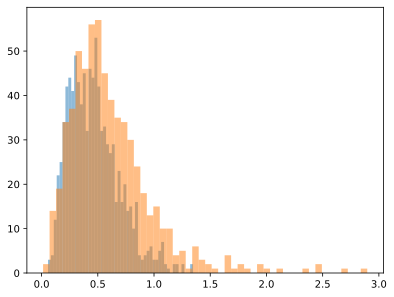

In [66]:

plt.hist(list(true_tavg_t1_msds[-1].values()),bins=50,alpha=0.5)
plt.hist(np.array(list(extracted_tavg_t1_msds[-1].values())),bins=50,alpha=0.5)
print(np.mean(list(true_tavg_t1_msds[0].values())))
print(np.mean(list(extracted_tavg_t1_msds[0].values())))

In [48]:
print(true_tracks.keys())
print(extracted_tracks.keys())
print(sorted(list(true_point_pairs.keys())))
print(sorted(list(extracted_point_pairs.keys())))

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219,

In [116]:
#import KS test
from scipy.stats import ks_2samp
def KS_testing_util(dist_1,dist_2):
    #we use the true distribution as the first argument and the extracted distribution as the second argument
    #this is because we want to know if the extracted distribution is the same as the true distribution
    #we return the p value of the KS test for each distribution
    ks_test_pvals = np.zeros((len(dist_1)))
    for i in range(len(dist_1)):
        print("KS test for {0}".format(i))
        print(ks_2samp(list(dist_1[i].values()),list(dist_2[i].values())))
        ks_test_pvals[i] = ks_2samp(list(dist_1[i].values()),list(dist_2[i].values()))[1]
    return ks_test_pvals

ks_test_pvals = KS_testing_util(true_tavg_t1_msds,extracted_tavg_t1_msds)

def mean_diffusion_error(dist_1,dist_2):
    #we use the true distribution as the first argument and the extracted distribution as the second argument
    #this is because we want to know if the extracted distribution is the same as the true distribution
    mean_error = np.zeros((len(dist_1)))
    for i in range(len(dist_1)):
        print("mean diffusion error for {0}".format(i))
        print(np.mean(list(dist_1[i].values()))-np.mean(list(dist_2[i].values())))
        mean_error[i] = np.abs(np.mean(list(dist_1[i].values()))-np.mean(list(dist_2[i].values())))/np.mean(list(dist_1[i].values()))
    return mean_error
mean_dif_errors = mean_diffusion_error(true_tavg_t1_msds,extracted_tavg_t1_msds)

KS test for 0
KstestResult(statistic=0.18130434782608695, pvalue=0.07308460145365152)
KS test for 1
KstestResult(statistic=0.08761904761904762, pvalue=0.5949999052075641)
KS test for 2
KstestResult(statistic=0.10923728813559322, pvalue=0.19300732401565732)
KS test for 3
KstestResult(statistic=0.11516279069767442, pvalue=0.0843062130226372)
KS test for 4
KstestResult(statistic=0.11205128205128205, pvalue=0.0551663954545769)
KS test for 5
KstestResult(statistic=0.13818003913894325, pvalue=0.004021615423425522)
KS test for 6
KstestResult(statistic=0.11634969325153374, pvalue=0.01390303165413799)
KS test for 7
KstestResult(statistic=0.12057971014492753, pvalue=0.006141541827018253)
KS test for 8
KstestResult(statistic=0.1252020725388601, pvalue=0.0019205534856002267)
KS test for 9
KstestResult(statistic=0.11789108266435236, pvalue=0.002415878746507059)
KS test for 10
KstestResult(statistic=0.16639737991266376, pvalue=9.297316252585826e-07)
KS test for 11
KstestResult(statistic=0.1637135278

In [50]:
#true_point_pairs["10.0,11.0"]
print(np.sum([len(point_pairs) for _,point_pairs in extracted_point_pairs.items()]))
print(np.sum([len(point_pairs) for _,point_pairs in true_point_pairs.items()]))
print(sim_maps[i])

4384
5700
/Volumes/Baljyot_HD/Sim_Data/sim_SMT_density_noaxial/h_0.2_track_100_diff_0.4_density_1.663


In [51]:
print(len(true_tracks.keys()))
print(len(extracted_tracks.keys()))

950
760


In [76]:
print(point_pair_errors)
print(sim_densities)

[94.5        92.11111111 85.91666667 82.93333333 85.5        79.38095238
 81.375      77.51851852 74.6        75.21212121 75.05555556 69.8974359
 70.11904762 68.62222222 64.0625     64.05882353 63.83333333 60.22807018]
[0.175, 0.263, 0.35, 0.438, 0.525, 0.613, 0.7, 0.787, 0.875, 0.963, 1.05, 1.137, 1.225, 1.312, 1.4, 1.488, 1.575, 1.663]


In [83]:
import tifffile as tiff
def load_tif_seg_random_plane(list_of_paths,plane= 300):
    #for each path in list_of_paths find the test_seg.tiff file and load it. Take the plane specified by plane and return it as a numpy array
    #return a list of numpy arrays
    #make a list to store the numpy arrays
    list_of_arrays = []
    for i in list_of_paths:
        #find the tiff file
        tiff_file = glob.glob(i+"/test_seg.tiff")
        #load the tiff file
        tiff_file = tiff.imread(tiff_file[0])
        #append the plane to the list_of_arrays
        list_of_arrays.append(tiff_file[plane])
    return list_of_arrays

planes = load_tif_seg_random_plane(sim_maps)

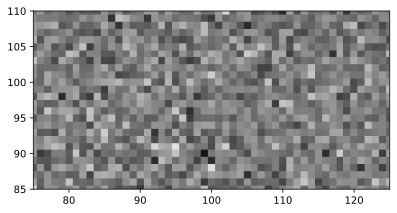

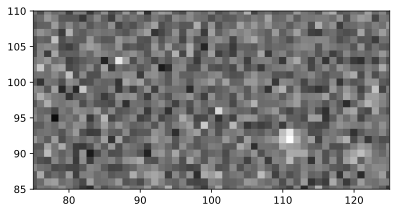

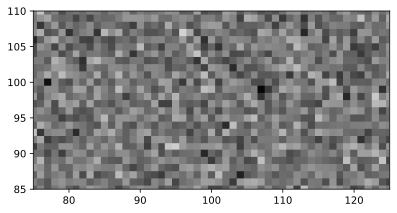

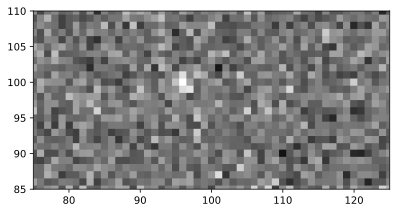

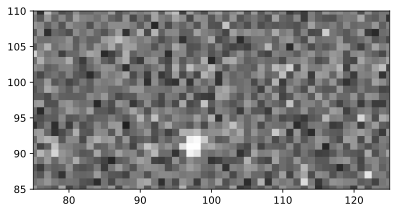

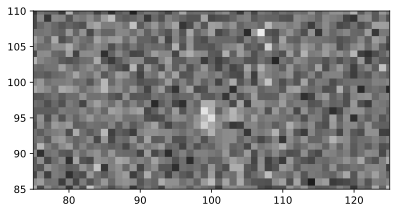

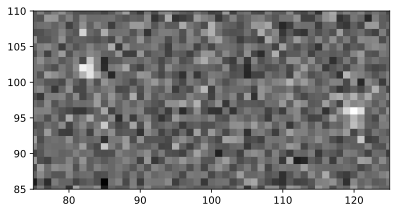

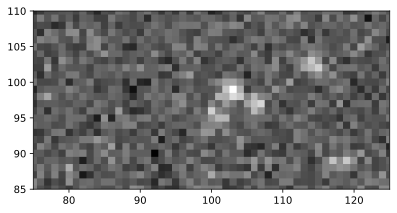

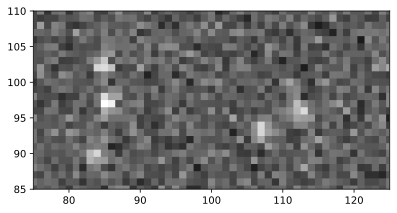

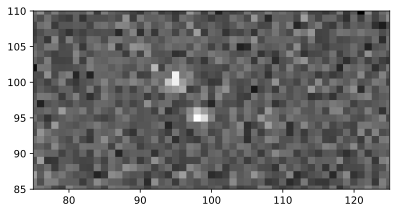

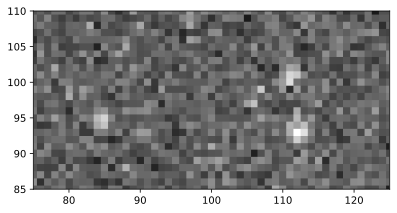

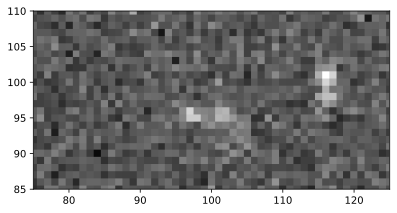

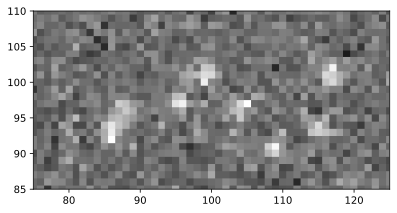

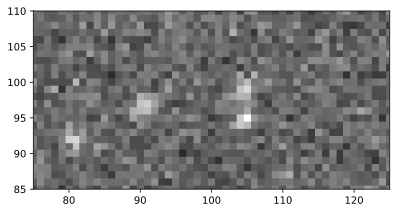

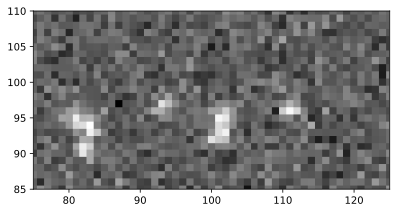

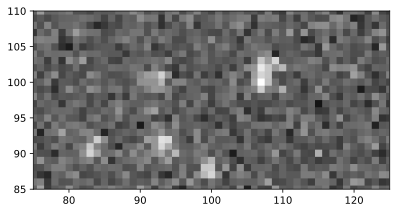

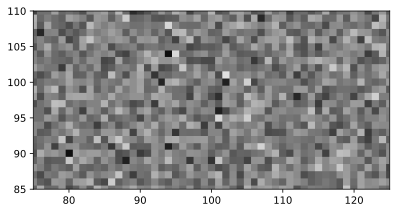

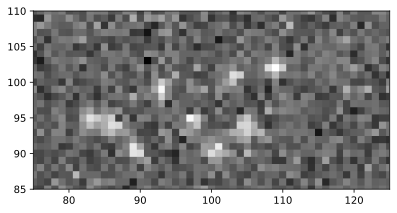

In [85]:
for i in planes:
    #fig,ax = plt.subplots(1,1,figsize=(10,10))
    plt.imshow(i,cmap="gray")
    #make the xlim and y lim [75,125] and [85,110]
    #make a rectangular box around [80,120] and [90,105]
    plt.xlim(75,125)
    plt.ylim(85,110)

    
    
    plt.show()

mean diffusion error for 0
-0.05447185468731458
mean diffusion error for 1
-0.01850771462836337
mean diffusion error for 2
-0.0506910894843835
mean diffusion error for 3
-0.06087015698675863
mean diffusion error for 4
-0.0557331904262891
mean diffusion error for 5
-0.0802887146266143
mean diffusion error for 6
-0.056006550078164574
mean diffusion error for 7
-0.0681835926057493
mean diffusion error for 8
-0.07373050229725636
mean diffusion error for 9
-0.08004475620651408
mean diffusion error for 10
-0.09263626063720992
mean diffusion error for 11
-0.09895255434234301
mean diffusion error for 12
-0.08787795139453969
mean diffusion error for 13
-0.11041163157182526
mean diffusion error for 14
-0.12075355239989194
mean diffusion error for 15
-0.1258332854882201
mean diffusion error for 16
-0.10279463476018563
mean diffusion error for 17
-0.1447009759298778


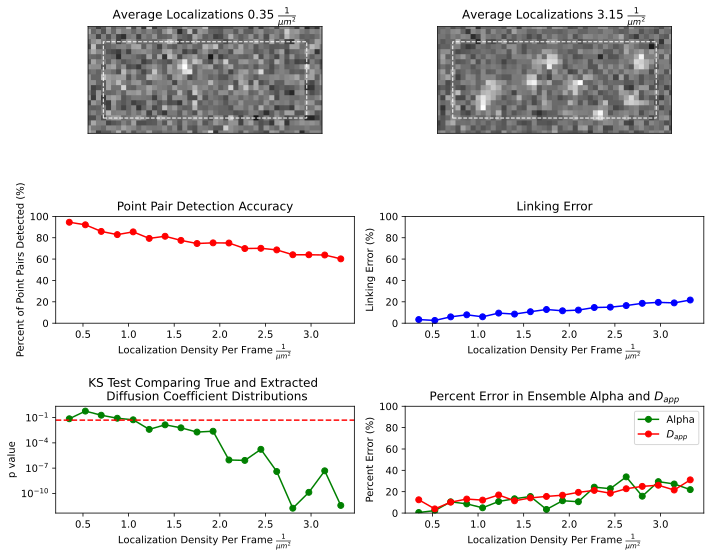

In [122]:
import matplotlib.patches as patches
#plt.plot(sim_densities,point_pair_errors)
fig = plt.figure(figsize=(10,10))
gs = fig.add_gridspec(4, 2)


ax3 = fig.add_subplot(gs[0, 0])
ax3.imshow(planes[3],cmap="gray")
ax3.set_xlim(77,123)
ax3.set_ylim(87,108)
#make a rectangular box around [80,120] and [90,105]
rect = patches.Rectangle((80,90),40,15,linewidth=1,edgecolor='w',facecolor='none',linestyle="--")
ax3.add_patch(rect)
ax3.set_title("Average Localizations {0}".format(sim_densities[0]*2) + r" $\frac{1}{\mu m^2}$")

ax4 = fig.add_subplot(gs[0, 1])
ax4.imshow(planes[12],cmap="gray")
ax4.set_xlim(77,123)
ax4.set_ylim(87,108)
#make a rectangular box around [80,120] and [90,105]
rect = patches.Rectangle((80,90),40,15,linewidth=1,edgecolor='w',facecolor='none',linestyle="--")
ax4.add_patch(rect)
ax4.set_title("Average Localizations {0}".format(sim_densities[16]*2) + r" $\frac{1}{\mu m^2}$")

#remove the x and y ticks from ax3,ax4
ax3.set_xticks([])
ax3.set_yticks([])
ax4.set_xticks([])
ax4.set_yticks([])




ax1 = fig.add_subplot(gs[1, 0])
sim_densities = np.array(sim_densities)
ax1.plot(sim_densities*2,point_pair_errors,marker="o",color="red")
ax1.set_xlabel(r"Localization Density Per Frame $\frac{1}{\mu m^2}$")
ax1.set_ylabel("Percent of Point Pairs Detected (%)")
ax1.set_ylim(0,100)
ax1.set_title("Point Pair Detection Accuracy")

ax2 = fig.add_subplot(gs[1, 1])
ax2.plot(sim_densities*2,linking_errors,marker="o",color="blue")
ax2.set_xlabel(r"Localization Density Per Frame $\frac{1}{\mu m^2}$")
ax2.set_ylabel("Linking Error (%)")
ax2.set_title("Linking Error")
ax2.set_ylim(0,100)


#plot the results of the KS test
ax5 = fig.add_subplot(gs[2, 0])
ax5.plot(sim_densities*2,ks_test_pvals,marker="o",color="green")
ax5.set_xlabel(r"Localization Density Per Frame $\frac{1}{\mu m^2}$")
ax5.set_ylabel("p value")
ax5.set_title("KS Test Comparing True and Extracted \n Diffusion Coefficient Distributions")
ax5.set_yscale("log")
#plot a horizontal line at 0.05
ax5.axhline(0.05,color="red",linestyle="--")



ax6 = fig.add_subplot(gs[2, 1])
alpha_error = 100*np.abs(true_alpha-extracted_alpha)/true_alpha
dif_error = mean_diffusion_error(true_tavg_t1_msds,extracted_tavg_t1_msds)*100

ax6.plot(sim_densities*2,alpha_error,marker="o",color="green")
ax6.plot(sim_densities*2,dif_error,marker="o",color="red")
ax6.set_xlabel(r"Localization Density Per Frame $\frac{1}{\mu m^2}$")
ax6.set_ylabel("Percent Error (%)")
ax6.set_title("Percent Error in Ensemble Alpha and" + r" $D_{app}$")
ax6.legend(["Alpha",r"$D_{app}$"])
ax6.set_ylim(0,100)






plt.tight_layout()

plt.show()

